In [33]:
import pandas as pd
import glob
import os
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import csv
import ast
from brokenaxes import brokenaxes

In [34]:
# find all CSVs one level up (kernel-survey)
csv_dir = os.path.abspath(os.path.join(os.getcwd(), '..'))
csv_files = glob.glob(os.path.join(csv_dir, '*.csv'))

# read each csv, tag with its filename, collect into a list
dfs = []
for path in csv_files:
    df = pd.read_csv(path, quotechar='"', quoting=csv.QUOTE_NONNUMERIC)
    df['filename'] = os.path.basename(path)
    dfs.append(df)

# concatenate all dataframes
df = pd.concat(dfs, ignore_index=True)

#df = df[df['modelName'] == 'google/gemini-2.5-flash-lite']
# keep only the gpt-4.1-mini model data
df = df[df['modelName'] == 'openai/gpt-4.1-mini']
print(df.shape)

# now you can explore or visualize
print(df.shape)
print(df.columns)

(361, 43)
(361, 43)
Index(['source_code', 'combined_name', 'kernel_name', 'exec_args', 'grid_size',
       'block_size', 'total_num_threads', 'empirical_sp_flop_count',
       'empirical_dp_flop_count', 'src_concretized_input_args',
       'step1_messages', 'concretizationState', 'src_single_kernel_execution',
       'step2_messages', 'srcSingleKernelState',
       'snippet_first_kernel_invocation', 'snippet_kernel_src',
       'snippet_kernel_src_concretized_values', 'step5_messages',
       'snippetConcretizationState', 'kernel_annotated_warp_divergence',
       'kernel_annotated_WDPs', 'wdps_list', 'wdp_processing_index',
       'wdps_num_executions', 'kernel_annotated_num_ops', 'step8_messages',
       'numOpsAnnotationState', 'summed_kernel_ops', 'sp_flop_diff',
       'dp_flop_diff', 'sp_flop_perc_diff', 'dp_flop_perc_diff',
       'input_tokens', 'output_tokens', 'total_cost', 'trial', 'modelName',
       'top_p', 'temp', 'totalQueryTime', 'error', 'filename'],
      dtype='obje

In [35]:
def classify_success(error_str):
    if error_str is np.nan:
        return 'Success'
    elif "QUERY TIMEOUT EVENT" in error_str:
        return 'Timeout'
    else:
        return 'Failed'

def sum_costs(cost_str):
    if cost_str is np.nan:
        return 0
    else:
        return sum(float(x) for x in ast.literal_eval(cost_str)) 

# add a success column
df['success'] = df['error'].apply(classify_success)
df['totalQueryTime'] = df['totalQueryTime'].astype(float)
df['total_query_cost'] = df['total_cost'].apply(sum_costs)

df['total_input_tokens'] = df['input_tokens'].apply(sum_costs)
df['total_output_tokens'] = df['output_tokens'].apply(sum_costs)

In [36]:
print(df.modelName.unique())

['openai/gpt-4.1-mini']


In [37]:
success_df = df[df['success'] == 'Success']

In [38]:
from dataclasses import dataclass
import re, ast

@dataclass
class FLOPCounts:
    sp_flop_count: int
    sp_flop_explanation: str
    dp_flop_count: int
    dp_flop_explanation: str

# only match our four fields
_flop_pattern = re.compile(
    r"(sp_flop_count|sp_flop_explanation|dp_flop_count|dp_flop_explanation)"
    r"=('(?:[^']*)'|\d+)"
)

def parse_flop_counts(ops_str):
    matches = _flop_pattern.findall(ops_str)
    d = {}
    for k, v in matches:
        if v.startswith("'"):
            d[k] = ast.literal_eval(v)
        else:
            d[k] = int(v)
    # fill in defaults in case any key is missing
    out = FLOPCounts(
        sp_flop_count       = d.get("sp_flop_count", 0),
        sp_flop_explanation = d.get("sp_flop_explanation", ""),
        dp_flop_count       = d.get("dp_flop_count", 0),
        dp_flop_explanation = d.get("dp_flop_explanation", "")
    )
    return out

success_df['flop_counts'] = (
    success_df['summed_kernel_ops']
      .apply(parse_flop_counts)
)

success_df['sp_flop_predicted'] = success_df['flop_counts'].apply(lambda x: x.sp_flop_count)
success_df['sp_flop_explanation'] = success_df['flop_counts'].apply(lambda x: x.sp_flop_explanation)
success_df['dp_flop_predicted'] = success_df['flop_counts'].apply(lambda x: x.dp_flop_count)
success_df['dp_flop_explanation'] = success_df['flop_counts'].apply(lambda x: x.dp_flop_explanation)

/var/folders/3g/gqtlwym54qj00m_k586jkf0w0000gn/T/ipykernel_48292/2083037434.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  success_df['flop_counts'] = (
/var/folders/3g/gqtlwym54qj00m_k586jkf0w0000gn/T/ipykernel_48292/2083037434.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  success_df['sp_flop_predicted'] = success_df['flop_counts'].apply(lambda x: x.sp_flop_count)
/var/folders/3g/gqtlwym54qj00m_k586jkf0w0000gn/T/ipykernel_48292/2083037434.py:40: SettingWithCopyWarning: 
A value is trying to be

In [39]:
print(success_df.shape, success_df.columns)

(270, 52) Index(['source_code', 'combined_name', 'kernel_name', 'exec_args', 'grid_size',
       'block_size', 'total_num_threads', 'empirical_sp_flop_count',
       'empirical_dp_flop_count', 'src_concretized_input_args',
       'step1_messages', 'concretizationState', 'src_single_kernel_execution',
       'step2_messages', 'srcSingleKernelState',
       'snippet_first_kernel_invocation', 'snippet_kernel_src',
       'snippet_kernel_src_concretized_values', 'step5_messages',
       'snippetConcretizationState', 'kernel_annotated_warp_divergence',
       'kernel_annotated_WDPs', 'wdps_list', 'wdp_processing_index',
       'wdps_num_executions', 'kernel_annotated_num_ops', 'step8_messages',
       'numOpsAnnotationState', 'summed_kernel_ops', 'sp_flop_diff',
       'dp_flop_diff', 'sp_flop_perc_diff', 'dp_flop_perc_diff',
       'input_tokens', 'output_tokens', 'total_cost', 'trial', 'modelName',
       'top_p', 'temp', 'totalQueryTime', 'error', 'filename', 'success',
       'total_que

In [40]:

success_df['sp_abs_perc_error'] = success_df.apply(
    lambda row: abs(row['sp_flop_predicted'] - row['empirical_sp_flop_count']) * 100 / row['empirical_sp_flop_count'] if row['empirical_sp_flop_count'] != 0 else 0,
    axis=1
)

success_df['sp_perc_error'] = success_df.apply(
    lambda row: (row['sp_flop_predicted'] - row['empirical_sp_flop_count']) * 100 / row['empirical_sp_flop_count'] if row['empirical_sp_flop_count'] != 0 else 0,
    axis=1
)

success_df['dp_abs_perc_error'] = success_df.apply(
    lambda row: abs(row['dp_flop_predicted'] - row['empirical_dp_flop_count']) * 100 / row['empirical_dp_flop_count'] if row['empirical_dp_flop_count'] != 0 else 0,
    axis=1
)

success_df['dp_perc_error'] = success_df.apply(
    lambda row: (row['dp_flop_predicted'] - row['empirical_dp_flop_count']) * 100 / row['empirical_dp_flop_count'] if row['empirical_dp_flop_count'] != 0 else 0,
    axis=1
)


/var/folders/3g/gqtlwym54qj00m_k586jkf0w0000gn/T/ipykernel_48292/2533747368.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  success_df['sp_abs_perc_error'] = success_df.apply(
/var/folders/3g/gqtlwym54qj00m_k586jkf0w0000gn/T/ipykernel_48292/2533747368.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  success_df['sp_perc_error'] = success_df.apply(
/var/folders/3g/gqtlwym54qj00m_k586jkf0w0000gn/T/ipykernel_48292/2533747368.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice

In [41]:
nnz_sp_flop_df = success_df[success_df['empirical_sp_flop_count'] > 0]

nnz_dp_flop_df = success_df[success_df['empirical_dp_flop_count'] > 0]

print(nnz_sp_flop_df.shape, nnz_dp_flop_df.shape)
print(nnz_sp_flop_df.columns)

(213, 56) (84, 56)
Index(['source_code', 'combined_name', 'kernel_name', 'exec_args', 'grid_size',
       'block_size', 'total_num_threads', 'empirical_sp_flop_count',
       'empirical_dp_flop_count', 'src_concretized_input_args',
       'step1_messages', 'concretizationState', 'src_single_kernel_execution',
       'step2_messages', 'srcSingleKernelState',
       'snippet_first_kernel_invocation', 'snippet_kernel_src',
       'snippet_kernel_src_concretized_values', 'step5_messages',
       'snippetConcretizationState', 'kernel_annotated_warp_divergence',
       'kernel_annotated_WDPs', 'wdps_list', 'wdp_processing_index',
       'wdps_num_executions', 'kernel_annotated_num_ops', 'step8_messages',
       'numOpsAnnotationState', 'summed_kernel_ops', 'sp_flop_diff',
       'dp_flop_diff', 'sp_flop_perc_diff', 'dp_flop_perc_diff',
       'input_tokens', 'output_tokens', 'total_cost', 'trial', 'modelName',
       'top_p', 'temp', 'totalQueryTime', 'error', 'filename', 'success',
       '

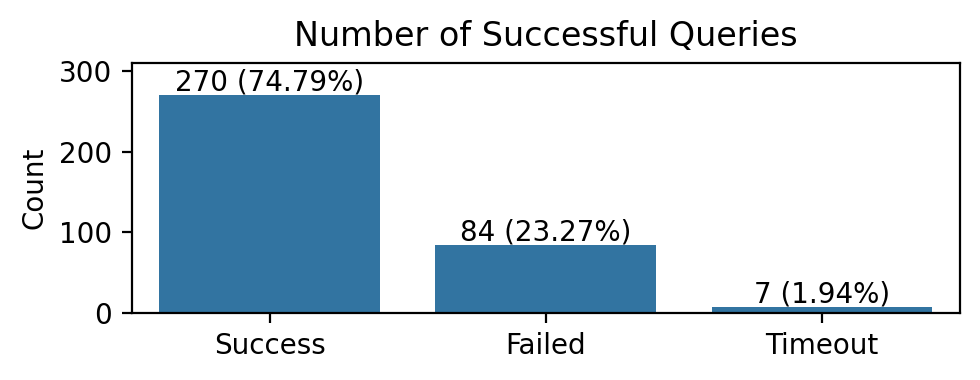

In [42]:
# make a seaborn plot showing the number of successful and not-successful elements in the df

plt.figure(figsize=(5, 2), dpi=200)
ax = sns.countplot(x='success', data=df)

# adjust y-limit so annotations fit
max_count = df['success'].value_counts().max()
ax.set_ylim(0, max_count * 1.15)

# add count labels on top of each bar
for p in ax.patches:
    count = int(p.get_height())
    percent = count / len(df) * 100
    ax.text(
        p.get_x() + p.get_width() / 2,
        p.get_height() + max_count * 0.02,
        f"{count} ({percent:.2f}%)",
        ha='center'
    )

#plt.xlabel('Outcome')
plt.xlabel('')
plt.ylabel('Count')
plt.title('Number of Successful Queries')
#plt.xticks([0, 1], ['Failed', 'Successful'])
plt.tight_layout()
plt.show()

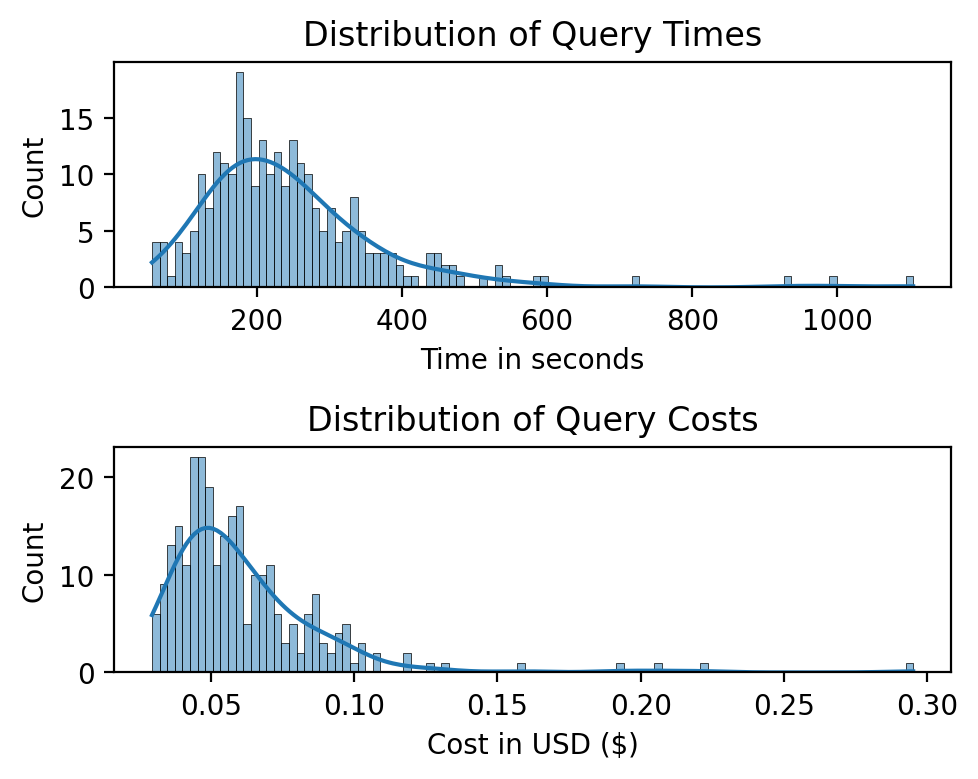

In [43]:
# now let's check the distribution of the query times and costs on two axes
bins = 100
fig, (ax1, ax2) = plt.subplots(2, 1,
                               figsize=(5, 4),  # taller to fit both
                               dpi=200,
                               sharex=False)   # you can set True if you want to share x
sns.histplot(success_df['totalQueryTime'], bins=bins, kde=True, ax=ax1)
ax1.set_title('Distribution of Query Times')
ax1.set_xlabel('Time in seconds')
ax1.set_ylabel('Count')

sns.histplot(success_df['total_query_cost'], bins=bins, kde=True, ax=ax2)
ax2.set_title('Distribution of Query Costs')
ax2.set_xlabel('Cost in USD ($)')
ax2.set_ylabel('Count')

plt.tight_layout()
plt.show()

Covariance matrix:
 [[ 8.90661507e-11 -2.19612195e-08]
 [-2.19612195e-08  6.99357355e-06]]


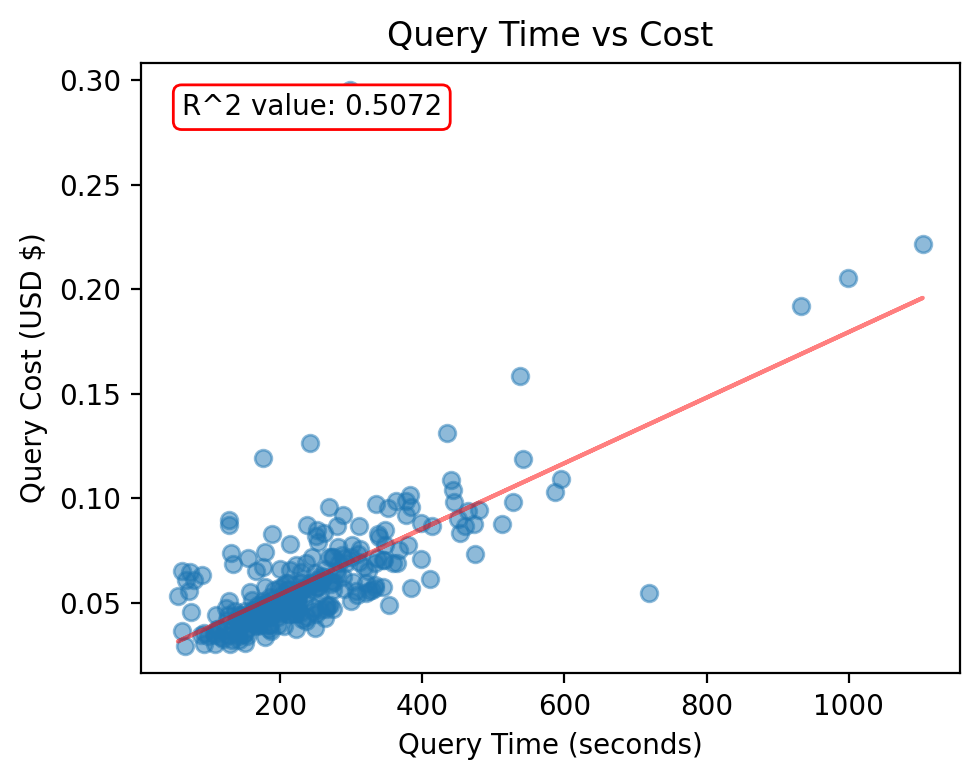

In [44]:
# scatter plot of query time vs cost
fig, ax = plt.subplots(1, 1, figsize=(5, 4), dpi=200)
ax.scatter(success_df['totalQueryTime'], success_df['total_query_cost'], alpha=0.5)

# display a line of best fit
z, cov = np.polyfit(success_df['totalQueryTime'],
                    success_df['total_query_cost'],
                    deg=1, cov=True)
p = np.poly1d(z)
x = success_df['totalQueryTime'].values
predicted = p(x)
ax.plot(x, predicted, color='red', alpha=0.5)

# print the R^2 value on the plot
r_squared = np.corrcoef(success_df['totalQueryTime'], success_df['total_query_cost'])[0, 1] ** 2
ax.text(0.05, 0.95, f"R^2 value: {r_squared:.4f}", transform=ax.transAxes, fontsize=10,
        verticalalignment='top', bbox=dict(boxstyle='round,pad=0.3', edgecolor='red', facecolor='white'))

## compute per-point standard error of the prediction
#var_m = cov[0, 0]
#var_b = cov[1, 1]
#cov_mb = cov[0, 1]
#sigma_pred = np.sqrt(var_b + x**2 * var_m + 2 * x * cov_mb)
#
## 95% confidence band
#upper = predicted + 1.96 * sigma_pred
#lower = predicted - 1.96 * sigma_pred
#ax.fill_between(x, lower, upper, color='red', alpha=0.2)

print("Covariance matrix:\n", cov)

ax.set_xlabel('Query Time (seconds)')
ax.set_ylabel('Query Cost (USD $)')
ax.set_title('Query Time vs Cost')
plt.tight_layout()
plt.show()

min_sp_dp_flop: 0.0, max_sp_dp_flop: 268435456000


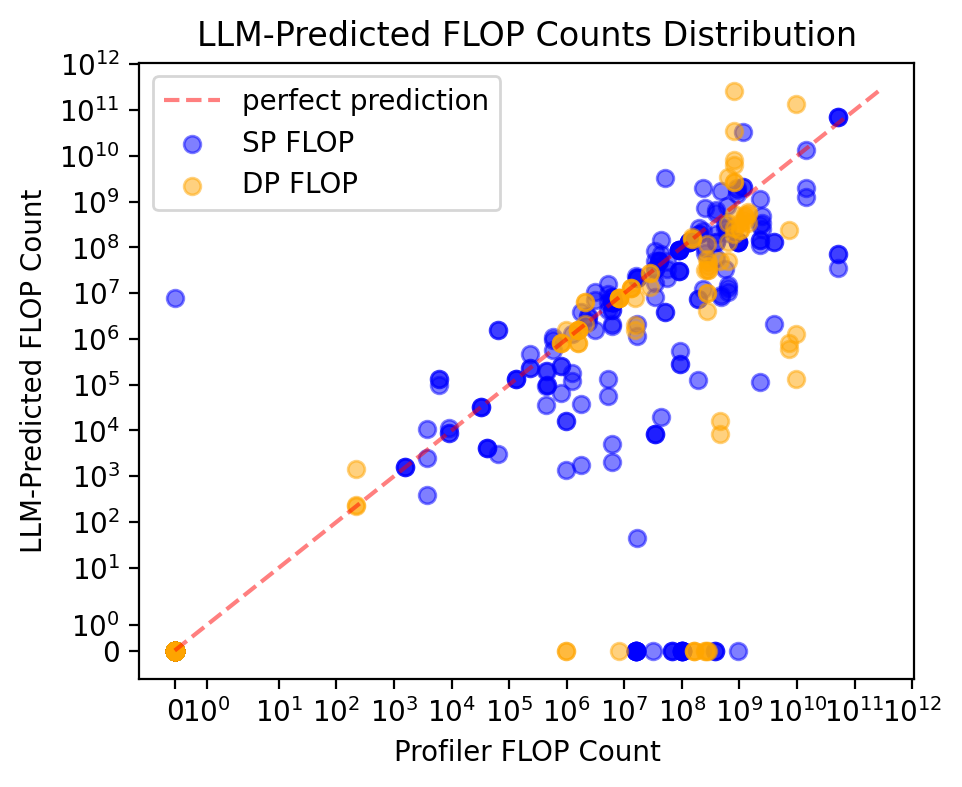

In [45]:
# now lets make a scatter plot of the predicted SP vs DP FLOP counts
fig, ax = plt.subplots(1, 1, figsize=(5, 4), dpi=200)

max_sp_dp_flop = max(
    success_df['empirical_sp_flop_count'].max(),
    success_df['empirical_dp_flop_count'].max(),
    success_df['sp_flop_predicted'].max(),
    success_df['dp_flop_predicted'].max()
)
min_sp_dp_flop = min(
    success_df['empirical_sp_flop_count'].min(),
    success_df['empirical_dp_flop_count'].min(),
    success_df['sp_flop_predicted'].min(),
    success_df['dp_flop_predicted'].min()
)

print(f"min_sp_dp_flop: {min_sp_dp_flop}, max_sp_dp_flop: {max_sp_dp_flop}")

# plot the x-y line on the plot
ax.plot([min_sp_dp_flop, max_sp_dp_flop], [min_sp_dp_flop, max_sp_dp_flop], color='red', linestyle='--', alpha=0.5, label='perfect prediction')

ax.scatter(success_df['empirical_sp_flop_count'], success_df['sp_flop_predicted'], alpha=0.5, label='SP FLOP', color='blue')
ax.scatter(success_df['empirical_dp_flop_count'], success_df['dp_flop_predicted'], alpha=0.5, label='DP FLOP', color='orange')


ax.set_xscale('symlog')
ax.set_yscale('symlog')

#ax.set_xlim(min_sp_dp_flop-100, max_sp_dp_flop)
#ax.set_ylim(min_sp_dp_flop-100, max_sp_dp_flop)
ax.set_title('LLM-Predicted FLOP Counts Distribution')
plt.xlabel('Profiler FLOP Count')
plt.ylabel('LLM-Predicted FLOP Count')
plt.legend()
plt.show()


In [46]:
print(success_df.shape, success_df.columns)

(270, 56) Index(['source_code', 'combined_name', 'kernel_name', 'exec_args', 'grid_size',
       'block_size', 'total_num_threads', 'empirical_sp_flop_count',
       'empirical_dp_flop_count', 'src_concretized_input_args',
       'step1_messages', 'concretizationState', 'src_single_kernel_execution',
       'step2_messages', 'srcSingleKernelState',
       'snippet_first_kernel_invocation', 'snippet_kernel_src',
       'snippet_kernel_src_concretized_values', 'step5_messages',
       'snippetConcretizationState', 'kernel_annotated_warp_divergence',
       'kernel_annotated_WDPs', 'wdps_list', 'wdp_processing_index',
       'wdps_num_executions', 'kernel_annotated_num_ops', 'step8_messages',
       'numOpsAnnotationState', 'summed_kernel_ops', 'sp_flop_diff',
       'dp_flop_diff', 'sp_flop_perc_diff', 'dp_flop_perc_diff',
       'input_tokens', 'output_tokens', 'total_cost', 'trial', 'modelName',
       'top_p', 'temp', 'totalQueryTime', 'error', 'filename', 'success',
       'total_que

In [47]:
# let's add a percent difference column for SP and DP FLOP counts

#nnz_sp_flop_df['sp_abs_perc_error'] = nnz_sp_flop_df.apply(
#    lambda row: abs(row['sp_flop_predicted'] - row['empirical_sp_flop_count']) * 100 / row['empirical_sp_flop_count'],
#    axis=1
#)
#
#nnz_sp_flop_df['sp_perc_error'] = nnz_sp_flop_df.apply(
#    lambda row: (row['sp_flop_predicted'] - row['empirical_sp_flop_count']) * 100 / row['empirical_sp_flop_count'],
#    axis=1
#)
#
#
#
#nnz_dp_flop_df['dp_abs_perc_error'] = nnz_dp_flop_df.apply(
#    lambda row: abs(row['dp_flop_predicted'] - row['empirical_dp_flop_count']) * 100 / row['empirical_dp_flop_count'],
#    axis=1
#)
#
#nnz_dp_flop_df['dp_perc_error'] = nnz_dp_flop_df.apply(
#    lambda row: (row['dp_flop_predicted'] - row['empirical_dp_flop_count']) * 100 / row['empirical_dp_flop_count'],
#    axis=1
#)


Text(0.5, 1.0, 'Distribution of Nonzero SP and DP FLOP Absolute Error')

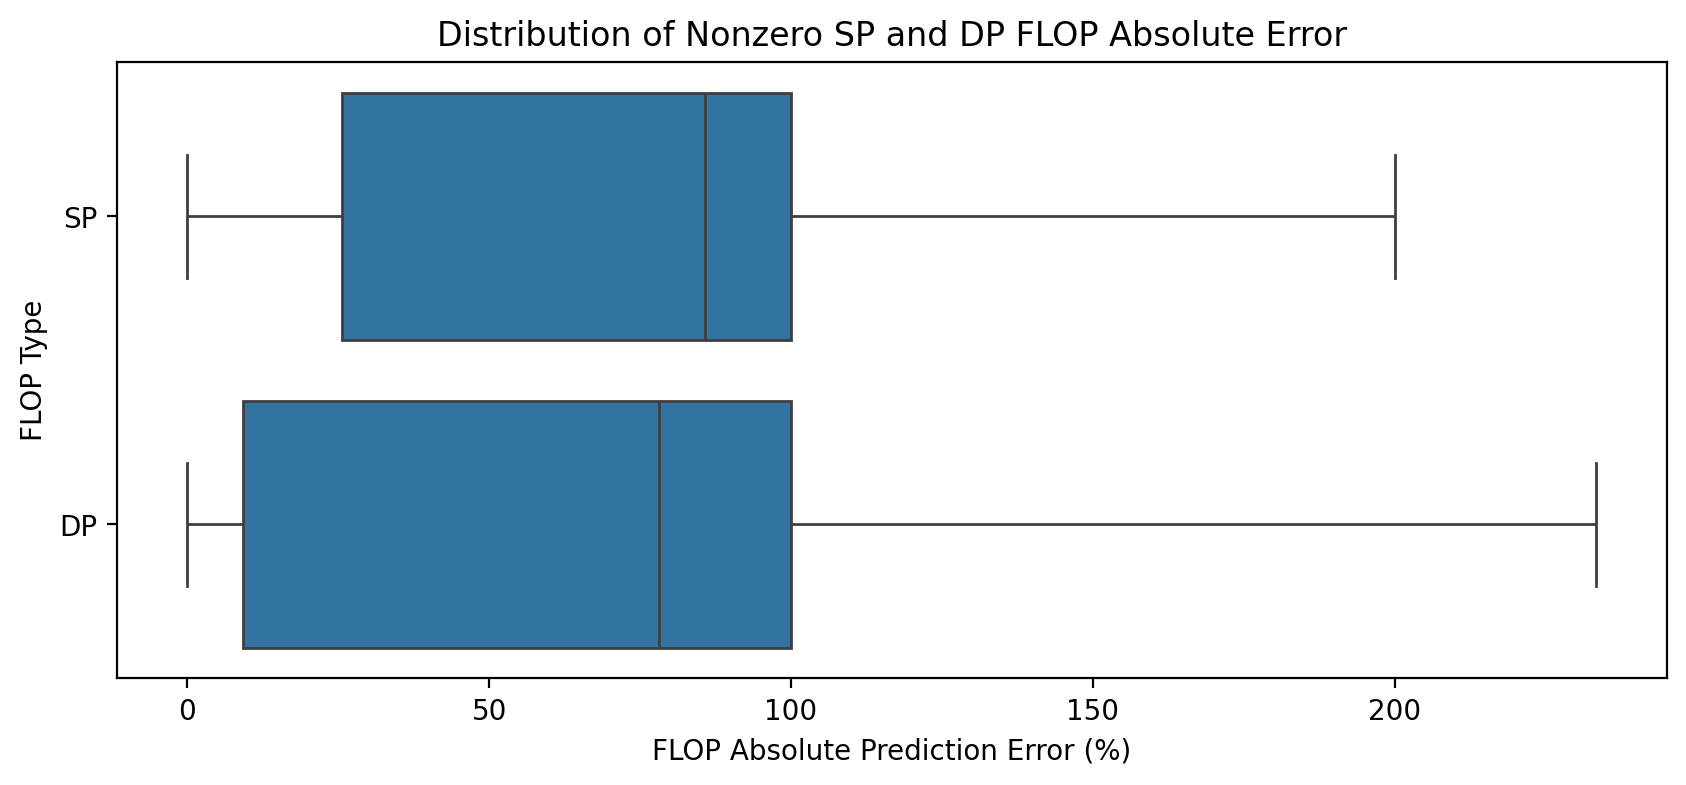

In [48]:
# let's look at the disitribution of the absolute prediction error (on nonzero FLOP counts)
merged = pd.DataFrame({
    'abs_perc_error' : np.concat([nnz_sp_flop_df['sp_abs_perc_error'], nnz_dp_flop_df['dp_abs_perc_error'] ]),
    'type' : ['SP'] * len(nnz_sp_flop_df) + ['DP'] * len(nnz_dp_flop_df)
})

fig, ax = plt.subplots(1, 1, figsize=(10, 4), dpi=200)

sns.boxplot(x='abs_perc_error', y='type', data=merged, ax=ax, orient='h', showfliers=False)

ax.set_xlabel('FLOP Absolute Prediction Error (%)')
ax.set_ylabel('FLOP Type')

ax.set_title('Distribution of Nonzero SP and DP FLOP Absolute Error')



                                    combined_name         mean          std  \
65             (streamcluster-cuda, compute_cost)  2243.287149  3725.770793   
39                       (lud-cuda, lud_internal)  1026.236488  1623.875545   
71                 (vol2col-cuda, col2vol_kernel)  1576.351247  1282.645722   
61                         (sosfil-cuda, sosfilt)   289.177140   421.499136   
44  (nlll-cuda, nll_loss_forward_reduce2d_kernel)  1900.493950   315.000038   
6            (backprop-cuda, kernel_layerforward)   138.472500    96.343172   
5          (backprop-cuda, kernel_adjust_weights)    99.992250    91.649794   
27                   (hogbom-cuda, k_subtractPSF)   133.971661    88.694687   
4                           (axhelm-cuda, axhelm)   148.817732    87.700677   
38                       (lud-cuda, lud_diagonal)   104.500927    79.708815   

    count  
65      3  
39      3  
71      3  
61      3  
44      3  
6       3  
5       3  
27      3  
4       3  
38      3 

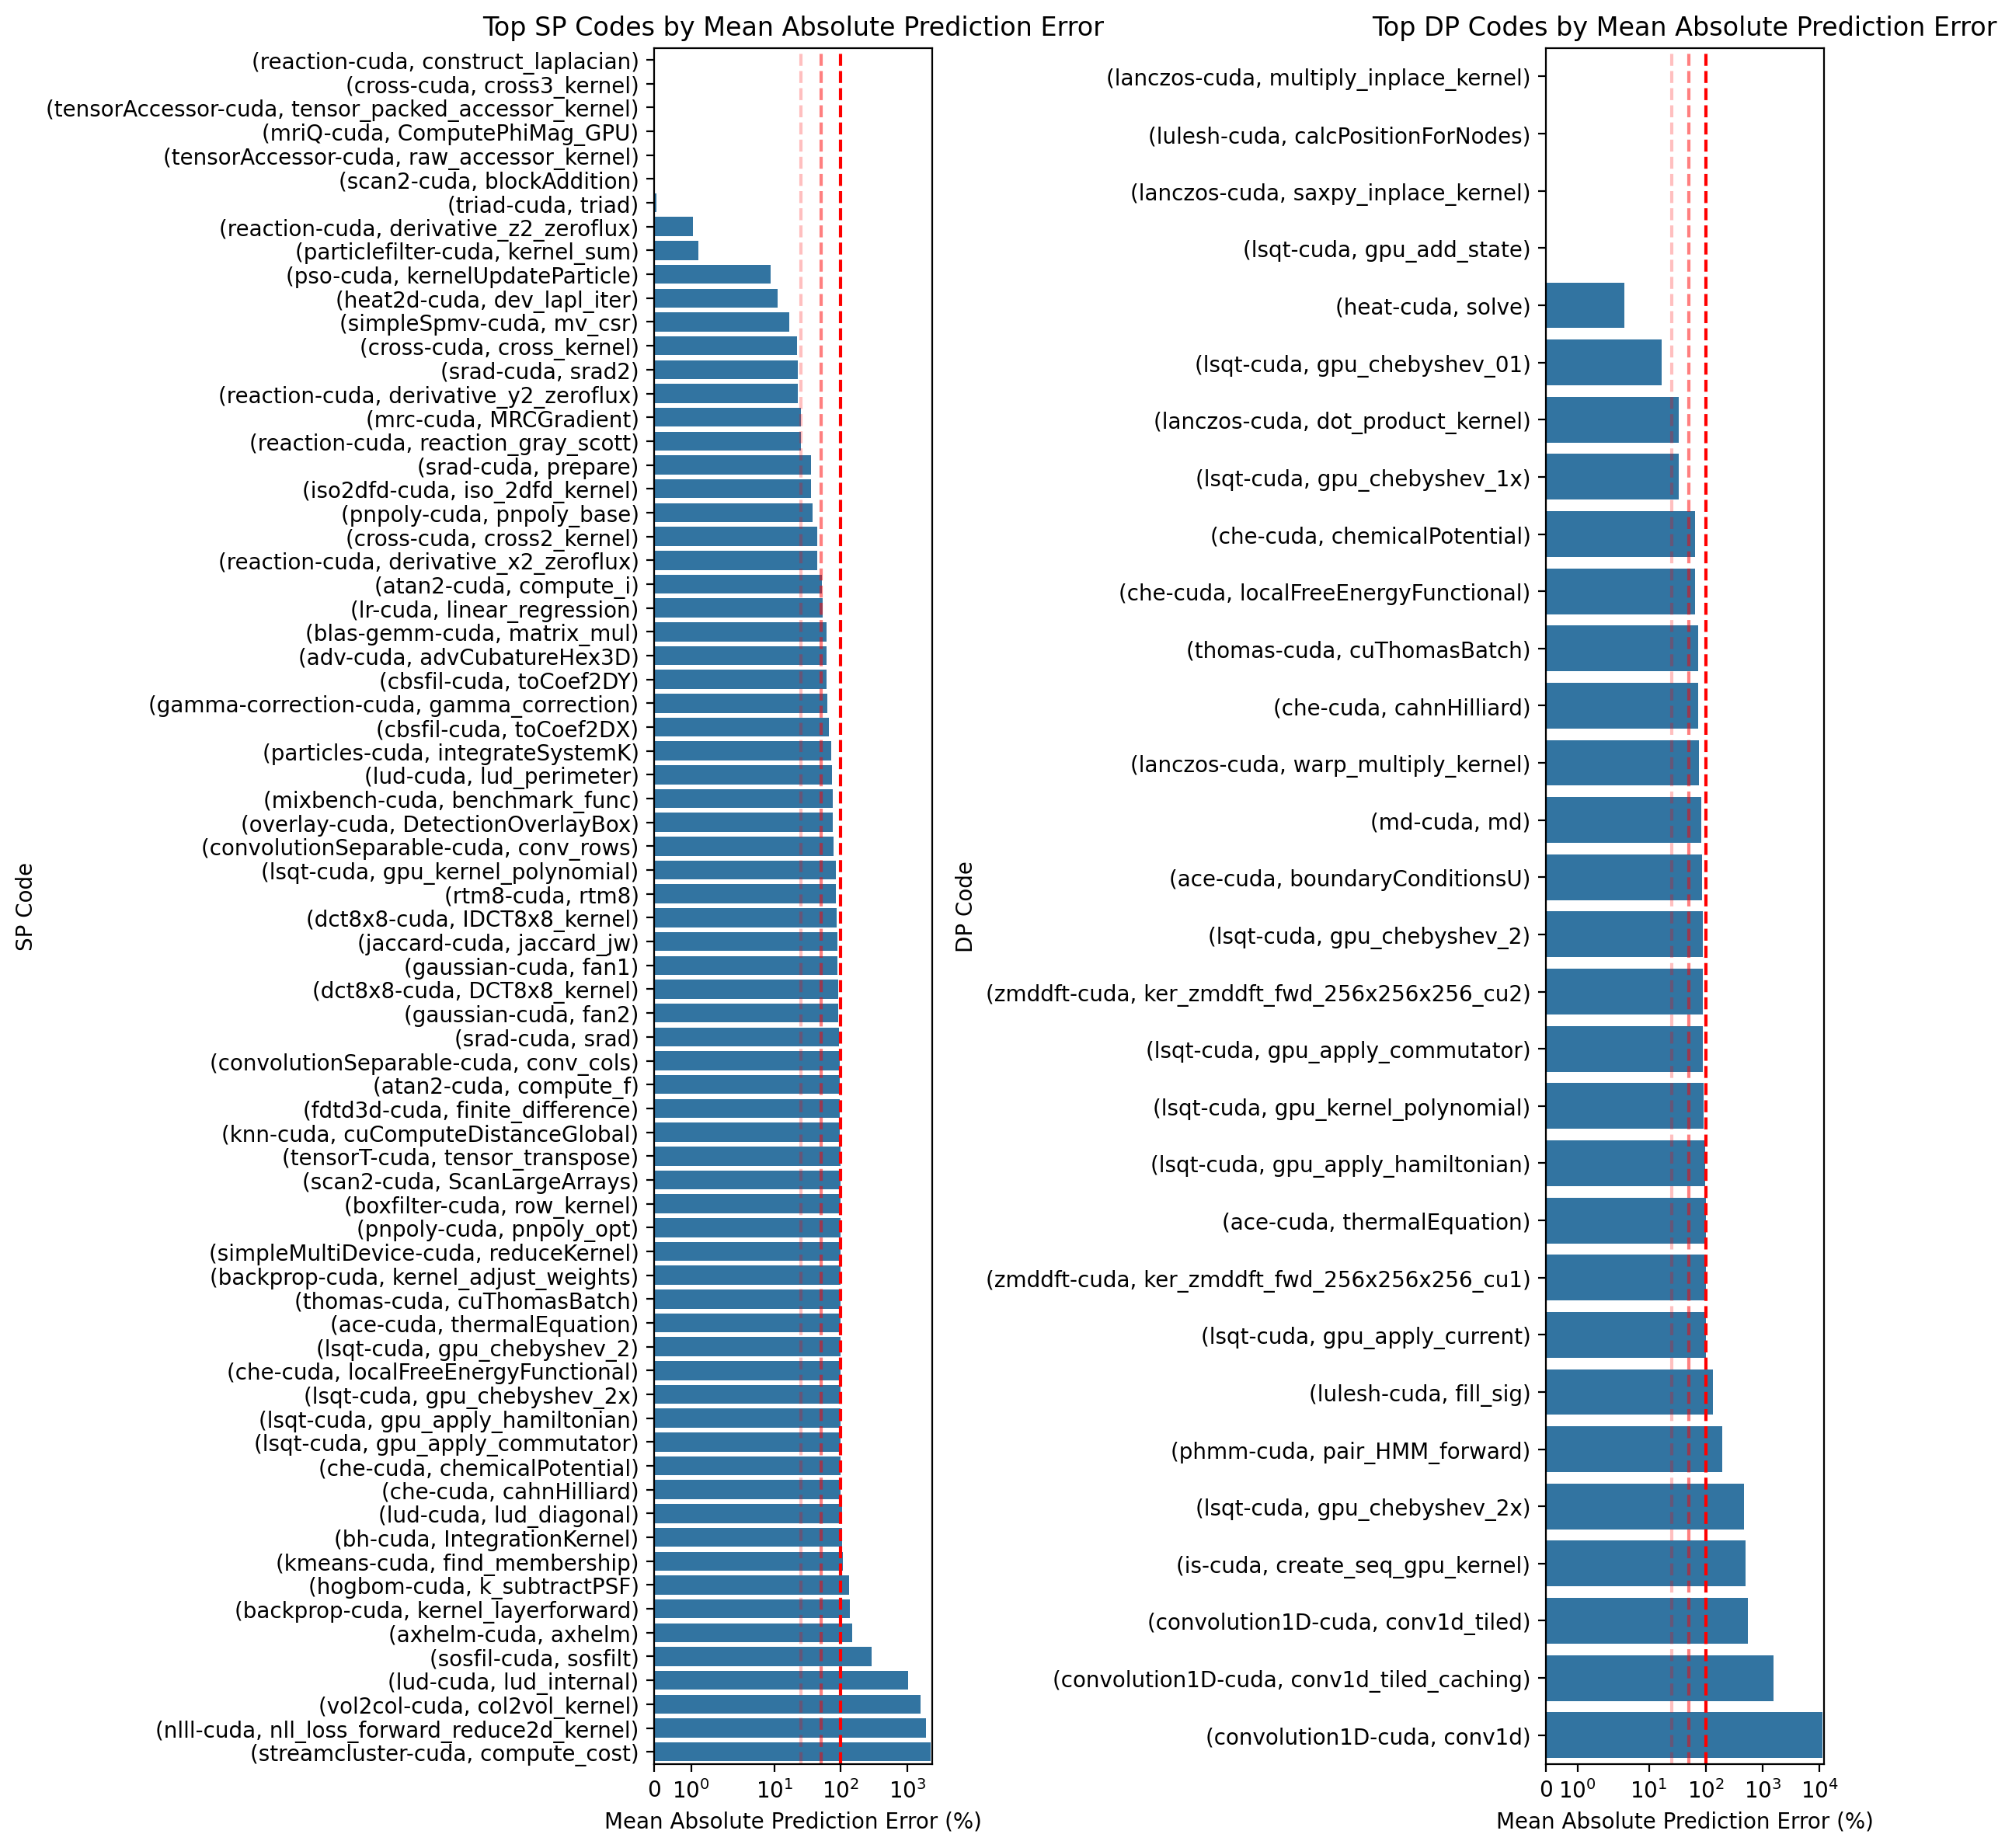

In [49]:
# let's check the codes with the largest prediction percent error variability
nnz_sp_flop_df_grouped = nnz_sp_flop_df.groupby('combined_name')['sp_abs_perc_error'].agg(['mean', 'std', 'count']).reset_index()
nnz_dp_flop_df_grouped = nnz_dp_flop_df.groupby('combined_name')['dp_abs_perc_error'].agg(['mean', 'std', 'count']).reset_index()

print(nnz_sp_flop_df_grouped.sort_values(by='std', ascending=False).head(10))
print(nnz_sp_flop_df_grouped.sort_values(by='std', ascending=True).head(10))
print()
print(nnz_dp_flop_df_grouped.sort_values(by='std', ascending=False).head(10))
print(nnz_dp_flop_df_grouped.sort_values(by='std', ascending=True).head(10))

# let's also plot the mean prediction error
fig, ax = plt.subplots(1, 2, figsize=(12, 12), dpi=200)

sns.barplot(x='mean', y='combined_name', data=nnz_sp_flop_df_grouped.sort_values(by='mean', ascending=True), ax=ax[0])
ax[0].set_title('Top SP Codes by Mean Absolute Prediction Error')
ax[0].set_xlabel('Mean Absolute Prediction Error (%)')
ax[0].set_ylabel('SP Code')

sns.barplot(x='mean', y='combined_name', data=nnz_dp_flop_df_grouped.sort_values(by='mean', ascending=True), ax=ax[1])
ax[1].set_title('Top DP Codes by Mean Absolute Prediction Error')
ax[1].set_xlabel('Mean Absolute Prediction Error (%)')
ax[1].set_ylabel('DP Code')

ax[0].axvline(100, color='red', linestyle='--', label='100% Error Threshold')
ax[1].axvline(100, color='red', linestyle='--', label='100% Error Threshold')

ax[0].axvline(50, color='red', alpha=0.5, linestyle='--', label='50% Error Threshold')
ax[1].axvline(50, color='red', alpha=0.5, linestyle='--', label='50% Error Threshold')

ax[0].axvline(25, color='red', alpha=0.25, linestyle='--', label='25% Error Threshold')
ax[1].axvline(25, color='red', alpha=0.25, linestyle='--', label='25% Error Threshold')

ax[0].set_xscale('symlog')
ax[1].set_xscale('symlog')

plt.tight_layout()
plt.show()

In [50]:
# let's create a plot similar to above, but for percent error (not)

                                    combined_name         mean          std  \
65             (streamcluster-cuda, compute_cost)  2120.337311  3832.248477   
39                       (lud-cuda, lud_internal)  1026.236488  1623.875545   
71                 (vol2col-cuda, col2vol_kernel)  1512.831552  1392.665059   
61                         (sosfil-cuda, sosfilt)   226.033194   475.878285   
44  (nlll-cuda, nll_loss_forward_reduce2d_kernel)  1900.493950   315.000038   
4                           (axhelm-cuda, axhelm)    17.906052   201.073480   
27                   (hogbom-cuda, k_subtractPSF)    67.334171   167.297701   
38                       (lud-cuda, lud_diagonal)    22.566411   148.223805   
30                 (kmeans-cuda, find_membership)    19.649963   147.912871   
6            (backprop-cuda, kernel_layerforward)   105.847856   145.733674   

    count  
65      3  
39      3  
71      3  
61      3  
44      3  
4       3  
27      3  
38      3  
30      3  
6       3 

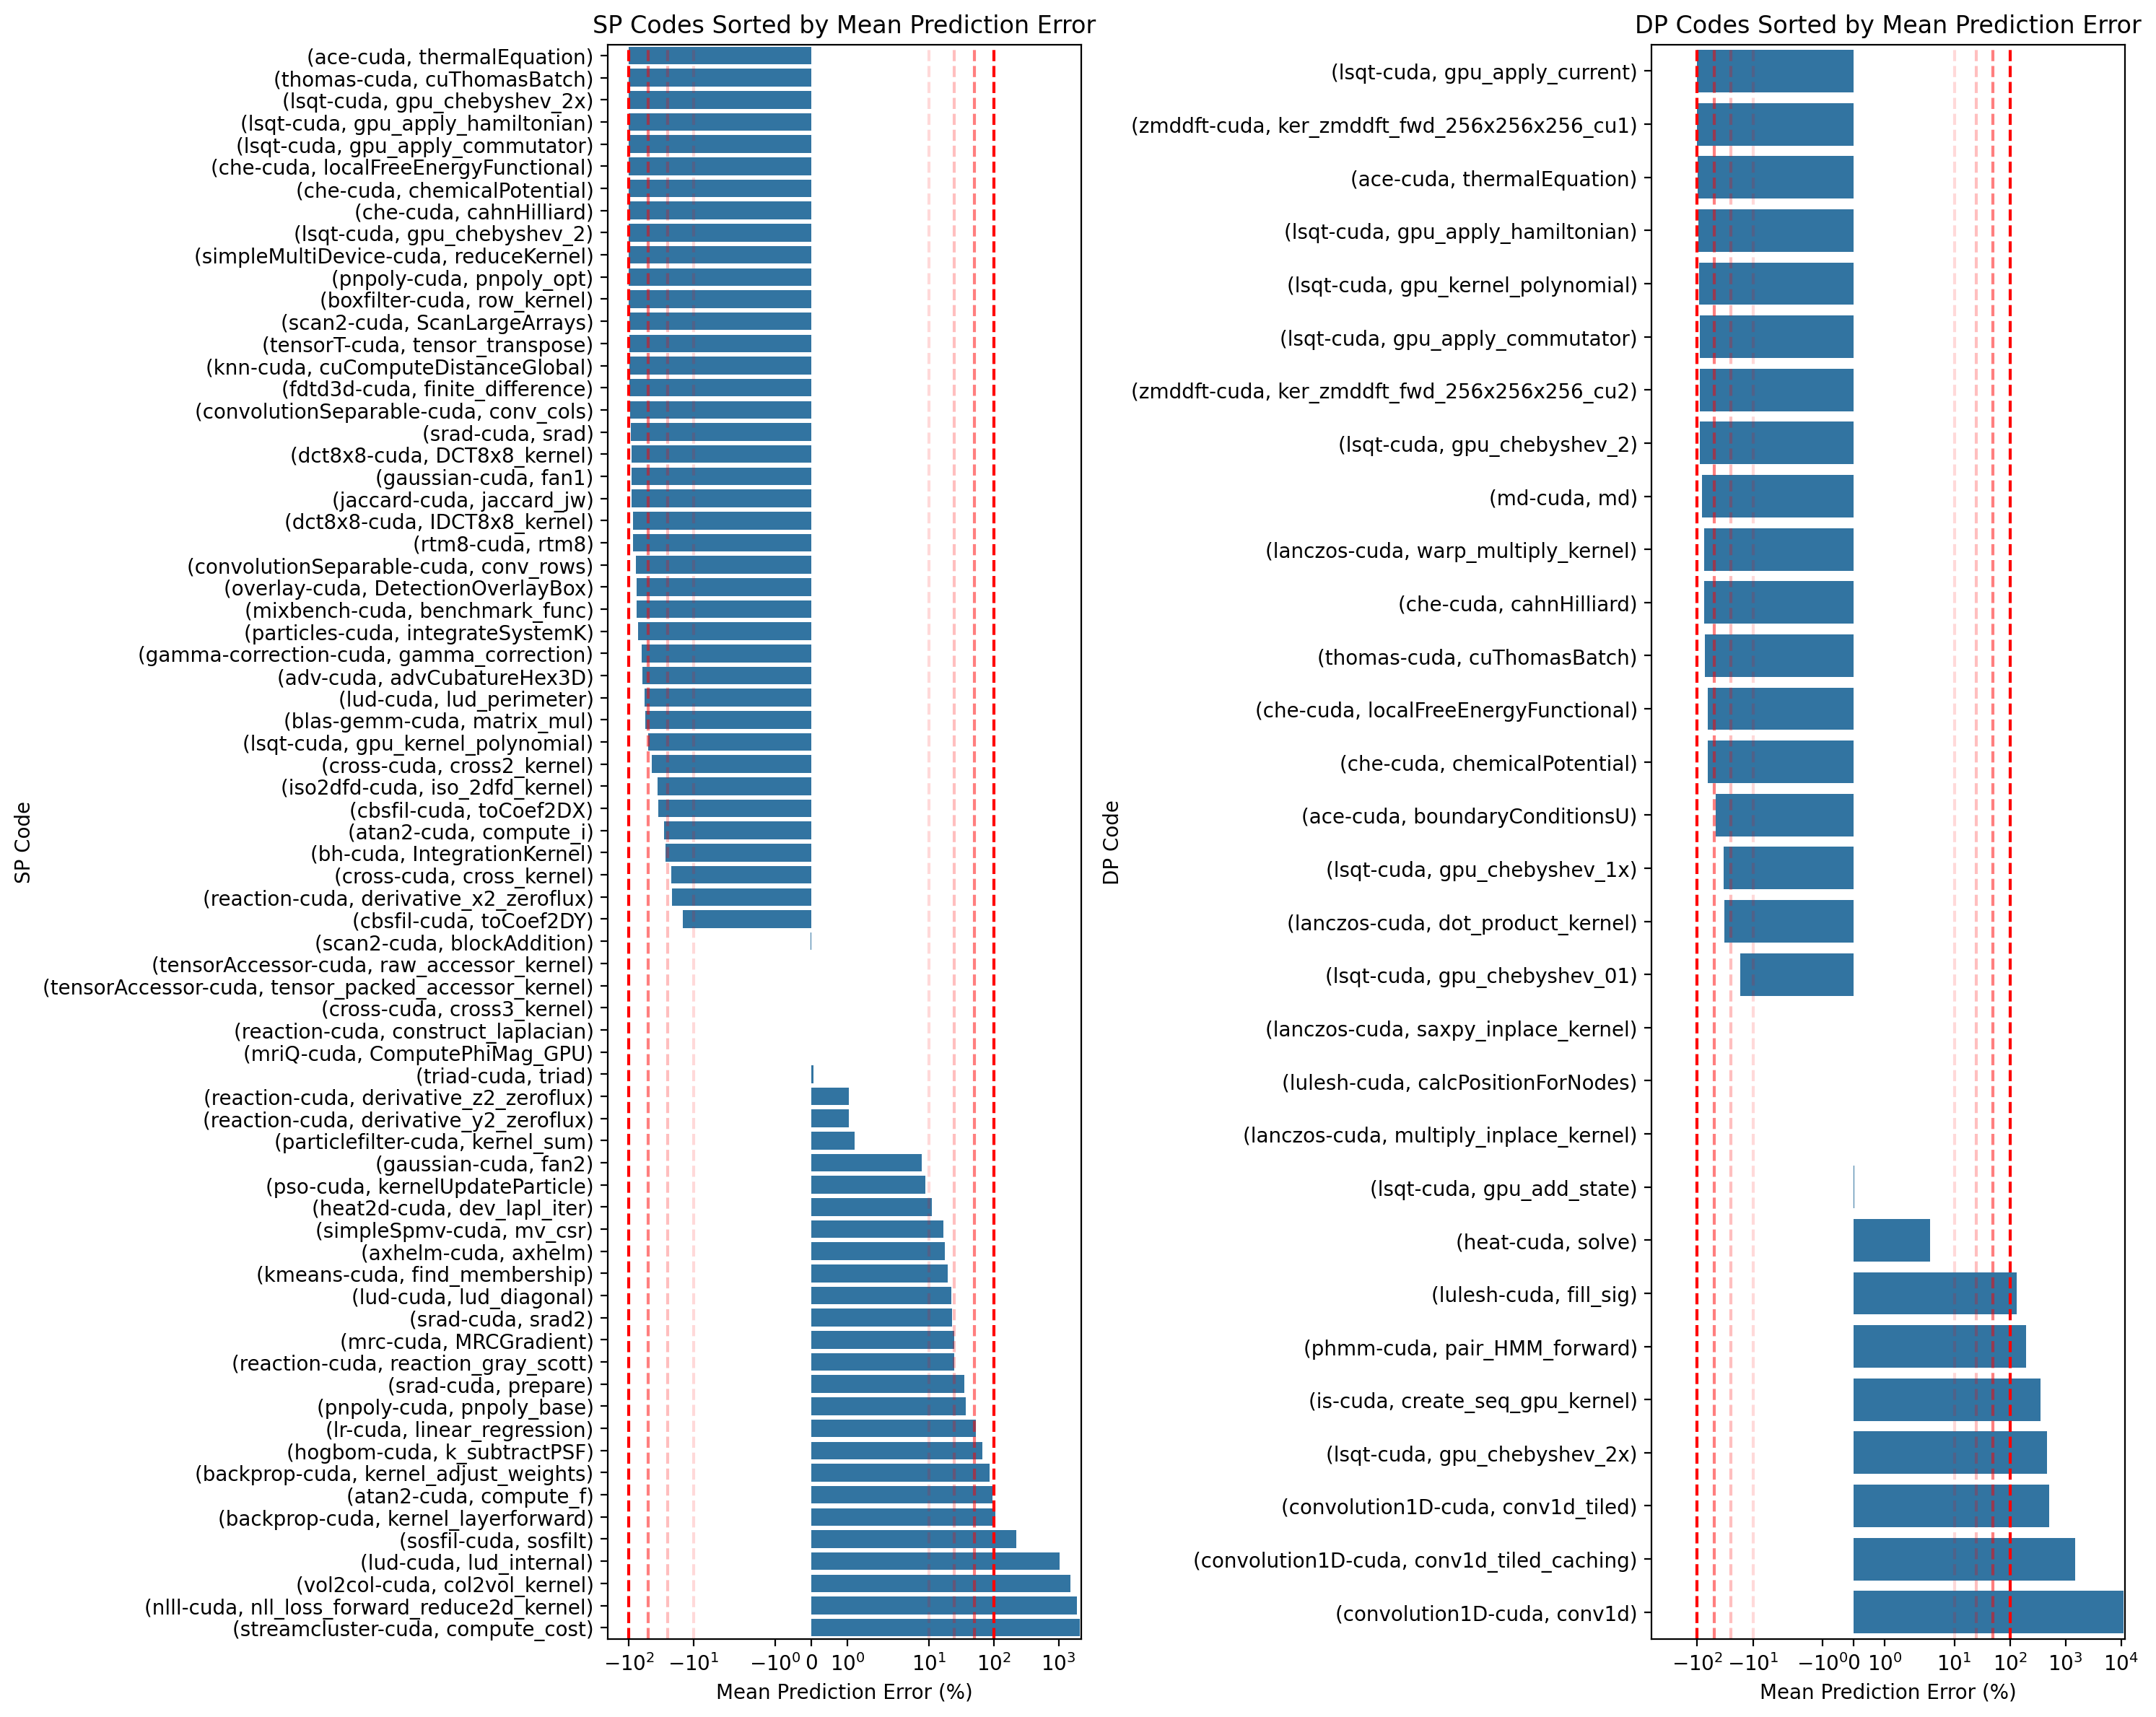

In [51]:
# let's check the codes with the largest prediction percent error variability
nnz_sp_flop_df_grouped = nnz_sp_flop_df.groupby('combined_name')['sp_perc_error'].agg(['mean', 'std', 'count']).reset_index()
nnz_dp_flop_df_grouped = nnz_dp_flop_df.groupby('combined_name')['dp_perc_error'].agg(['mean', 'std', 'count']).reset_index()

print(nnz_sp_flop_df_grouped.sort_values(by='std', ascending=False).head(10))
print(nnz_sp_flop_df_grouped.sort_values(by='std', ascending=True).head(10))
print()
print(nnz_dp_flop_df_grouped.sort_values(by='std', ascending=False).head(10))
print(nnz_dp_flop_df_grouped.sort_values(by='std', ascending=True).head(10))

#nnz_sp_flop_df['sp_perc_error_mean'] = nnz_sp_flop_df.groupby('combined_name')['sp_perc_error'].mean().reset_index(drop=True, name='sp_perc_error_mean')
#nnz_dp_flop_df['dp_perc_error_mean'] = nnz_dp_flop_df.groupby('combined_name')['dp_perc_error'].mean().reset_index(drop=True, name='dp_perc_error_mean')

print(nnz_sp_flop_df.columns)

# let's also plot the mean prediction error
fig, ax = plt.subplots(1, 2, figsize=(15, 12), dpi=200)

sns.barplot(x='mean', y='combined_name', errorbar='sd', data=nnz_sp_flop_df_grouped.sort_values(by='mean', ascending=True), ax=ax[0])
#sns.barplot(x='sp_perc_error_mean', y='combined_name', errorbar='sd', data=nnz_sp_flop_df.sort_values(by='sp_perc_error_mean'), ax=ax[0])
ax[0].set_title('SP Codes Sorted by Mean Prediction Error')
ax[0].set_xlabel('Mean Prediction Error (%)')
ax[0].set_ylabel('SP Code')

sns.barplot(x='mean', y='combined_name', errorbar='sd', data=nnz_dp_flop_df_grouped.sort_values(by='mean', ascending=True), ax=ax[1])
ax[1].set_title('DP Codes Sorted by Mean Prediction Error')
ax[1].set_xlabel('Mean Prediction Error (%)')
ax[1].set_ylabel('DP Code')

ax[0].axvline(100, color='red', linestyle='--', label='100% Error Threshold')
ax[1].axvline(100, color='red', linestyle='--', label='100% Error Threshold')
ax[0].axvline(-100, color='red', linestyle='--', label='100% Error Threshold')
ax[1].axvline(-100, color='red', linestyle='--', label='100% Error Threshold')

ax[0].axvline(50, color='red', alpha=0.5, linestyle='--', label='50% Error Threshold')
ax[1].axvline(50, color='red', alpha=0.5, linestyle='--', label='50% Error Threshold')
ax[0].axvline(-50, color='red', alpha=0.5, linestyle='--', label='50% Error Threshold')
ax[1].axvline(-50, color='red', alpha=0.5, linestyle='--', label='50% Error Threshold')

ax[0].axvline(25, color='red', alpha=0.25, linestyle='--', label='25% Error Threshold')
ax[1].axvline(25, color='red', alpha=0.25, linestyle='--', label='25% Error Threshold')
ax[0].axvline(-25, color='red', alpha=0.25, linestyle='--', label='25% Error Threshold')
ax[1].axvline(-25, color='red', alpha=0.25, linestyle='--', label='25% Error Threshold')

ax[0].axvline(10, color='red', alpha=0.15, linestyle='--', label='10% Error Threshold')
ax[1].axvline(10, color='red', alpha=0.15, linestyle='--', label='10% Error Threshold')
ax[0].axvline(-10, color='red', alpha=0.15, linestyle='--', label='10% Error Threshold')
ax[1].axvline(-10, color='red', alpha=0.15, linestyle='--', label='10% Error Threshold')

ax[0].set_xscale('symlog')
ax[1].set_xscale('symlog')

plt.tight_layout()
plt.show()

In [52]:
# write an Excel file with the dataframes
# we will be editing this file later to contain the reasons for the errors


In [53]:
print(nnz_sp_flop_df.columns)

Index(['source_code', 'combined_name', 'kernel_name', 'exec_args', 'grid_size',
       'block_size', 'total_num_threads', 'empirical_sp_flop_count',
       'empirical_dp_flop_count', 'src_concretized_input_args',
       'step1_messages', 'concretizationState', 'src_single_kernel_execution',
       'step2_messages', 'srcSingleKernelState',
       'snippet_first_kernel_invocation', 'snippet_kernel_src',
       'snippet_kernel_src_concretized_values', 'step5_messages',
       'snippetConcretizationState', 'kernel_annotated_warp_divergence',
       'kernel_annotated_WDPs', 'wdps_list', 'wdp_processing_index',
       'wdps_num_executions', 'kernel_annotated_num_ops', 'step8_messages',
       'numOpsAnnotationState', 'summed_kernel_ops', 'sp_flop_diff',
       'dp_flop_diff', 'sp_flop_perc_diff', 'dp_flop_perc_diff',
       'input_tokens', 'output_tokens', 'total_cost', 'trial', 'modelName',
       'top_p', 'temp', 'totalQueryTime', 'error', 'filename', 'success',
       'total_query_cost', 

In [54]:
# let's load up the manually processed data

errors_df = pd.read_csv('backup_done_manually_processed.csv')

In [55]:
print(errors_df.shape, errors_df.columns)

(270, 73) Index(['source_code', 'combined_name', 'kernel_name', 'exec_args', 'grid_size',
       'block_size', 'total_num_threads', 'empirical_sp_flop_count',
       'empirical_dp_flop_count', 'src_concretized_input_args',
       'step1_messages', 'concretizationState', 'src_single_kernel_execution',
       'step2_messages', 'srcSingleKernelState',
       'snippet_first_kernel_invocation', 'snippet_kernel_src',
       'snippet_kernel_src_concretized_values', 'step5_messages',
       'snippetConcretizationState', 'kernel_annotated_warp_divergence',
       'kernel_annotated_WDPs', 'wdps_list', 'wdp_processing_index',
       'wdps_num_executions', 'kernel_annotated_num_ops', 'step8_messages',
       'numOpsAnnotationState', 'summed_kernel_ops', 'sp_flop_diff',
       'dp_flop_diff', 'sp_flop_perc_diff', 'dp_flop_perc_diff',
       'input_tokens', 'output_tokens', 'total_cost', 'trial', 'modelName',
       'top_p', 'temp', 'totalQueryTime', 'error', 'filename', 'success',
       'total_que

In [56]:
def is_easy_code(row):
    return (row['hasSpecialMathFunctions'] == 0 and \
            row['hasFPDivisions'] == 0 and \
            row['hasDDBranching'] == 0 and \
            row['callsDeviceFunction'] == 0 and \
            row['hasCommonSubexpressions'] == 0)

errors_df['is_easy_code'] = errors_df.apply(is_easy_code, axis=1)

def missing_necessary_device_function(row):
    return row['snippetHasDeviceFunction'] == 0 and row['callsDeviceFunction'] == 1

errors_df['missing_necessary_device_function'] = errors_df.apply(missing_necessary_device_function, axis=1)

In [57]:
print(errors_df.combined_name.nunique())

92


In [66]:
nnz_sp_errors_df = errors_df[errors_df['empirical_sp_flop_count'] != 0]

#print(nnz_sp_errors_df.groupby(['is_easy_code', 'combined_name']).size())

nnz_dp_errors_df = errors_df[errors_df['empirical_dp_flop_count'] != 0]

#print(nnz_dp_errors_df.groupby(['is_easy_code', 'combined_name']).size())

print(nnz_sp_errors_df.shape, nnz_dp_errors_df.shape)

(213, 75) (84, 75)


In [59]:
zero_sp_errors_df = errors_df[errors_df['empirical_sp_flop_count'] == 0]

zero_dp_errors_df = errors_df[errors_df['empirical_dp_flop_count'] == 0]

print(zero_sp_errors_df.shape, zero_dp_errors_df.shape)

(57, 75) (186, 75)


In [60]:
error_bound = 25.0
def is_correct_prediction(row, sp_or_dp):
    # if the spExplanationHasCloseFLOPCount is 1
    if sp_or_dp == 'SP':
        is_correct_flop = (row['spExplanationHasCloseFLOPCount'] == 1) or (row['sp_abs_perc_error'] <= error_bound)
    elif sp_or_dp == 'DP':
        is_correct_flop = (row['dpExplanationHasCloseFLOPCount'] == 1) or (row['dp_abs_perc_error'] <= error_bound)
    else:
        raise ValueError("sp_or_dp must be either 'SP' or 'DP'")

    return is_correct_flop


nnz_sp_errors_df['is_correct_prediction'] = nnz_sp_errors_df.apply(lambda row: is_correct_prediction(row, 'SP'), axis=1)
nnz_dp_errors_df['is_correct_prediction'] = nnz_dp_errors_df.apply(lambda row: is_correct_prediction(row, 'DP'), axis=1)

easy_nnz_sp_errors_df = nnz_sp_errors_df[nnz_sp_errors_df['is_easy_code'] == True]
hard_nnz_sp_errors_df = nnz_sp_errors_df[nnz_sp_errors_df['is_easy_code'] == False]

easy_nnz_dp_errors_df = nnz_dp_errors_df[nnz_dp_errors_df['is_easy_code'] == True]
hard_nnz_dp_errors_df = nnz_dp_errors_df[nnz_dp_errors_df['is_easy_code'] == False]

print(nnz_sp_errors_df.shape, nnz_dp_errors_df.shape)
print(easy_nnz_sp_errors_df.is_correct_prediction.value_counts())
print(easy_nnz_dp_errors_df.is_correct_prediction.value_counts())

print("Median Easy SP Absolute Percent Error:", easy_nnz_sp_errors_df.sp_abs_perc_error.median())
print("Median Easy DP Absolute Percent Error:", easy_nnz_dp_errors_df.dp_abs_perc_error.median())

print("Median Hard SP Absolute Percent Error:", hard_nnz_sp_errors_df.sp_abs_perc_error.median())
print("Median Hard DP Absolute Percent Error:", hard_nnz_dp_errors_df.dp_abs_perc_error.median())

print("Num Codes in Easy NNZ SP:", easy_nnz_sp_errors_df.combined_name.nunique())
print("Num Codes in Easy NNZ DP:", easy_nnz_dp_errors_df.combined_name.nunique())
print("Num Codes in Hard NNZ SP:", hard_nnz_sp_errors_df.combined_name.nunique())
print("Num Codes in Hard NNZ DP:", hard_nnz_dp_errors_df.combined_name.nunique())

print("Num total Easy codes:", errors_df[errors_df['is_easy_code'] == True].combined_name.nunique())
print("Num total Hard codes:", errors_df[errors_df['is_easy_code'] == False].combined_name.nunique())
# number of codes with both nnz SP and DP
print("Num Codes with both NNZ SP and DP:", errors_df[(errors_df['empirical_sp_flop_count'] != 0) & (errors_df['empirical_dp_flop_count'] != 0)].combined_name.nunique())


(213, 76) (84, 76)
is_correct_prediction
True     63
False    57
Name: count, dtype: int64
is_correct_prediction
True     28
False    20
Name: count, dtype: int64
Median Easy SP Absolute Percent Error: 61.140473154484276
Median Easy DP Absolute Percent Error: 40.305526284855695
Median Hard SP Absolute Percent Error: 97.4606210332376
Median Hard DP Absolute Percent Error: 90.49437796928048
Num Codes in Easy NNZ SP: 40
Num Codes in Easy NNZ DP: 17
Num Codes in Hard NNZ SP: 32
Num Codes in Hard NNZ DP: 13
Num total Easy codes: 57
Num total Hard codes: 35
Num Codes with both NNZ SP and DP: 10


/var/folders/3g/gqtlwym54qj00m_k586jkf0w0000gn/T/ipykernel_48292/3101024886.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  nnz_sp_errors_df['is_correct_prediction'] = nnz_sp_errors_df.apply(lambda row: is_correct_prediction(row, 'SP'), axis=1)
/var/folders/3g/gqtlwym54qj00m_k586jkf0w0000gn/T/ipykernel_48292/3101024886.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  nnz_dp_errors_df['is_correct_prediction'] = nnz_dp_errors_df.apply(lambda row: is_correct_prediction(row, 'DP'), axis=1)


In [61]:
# error flags of the top mispredictions

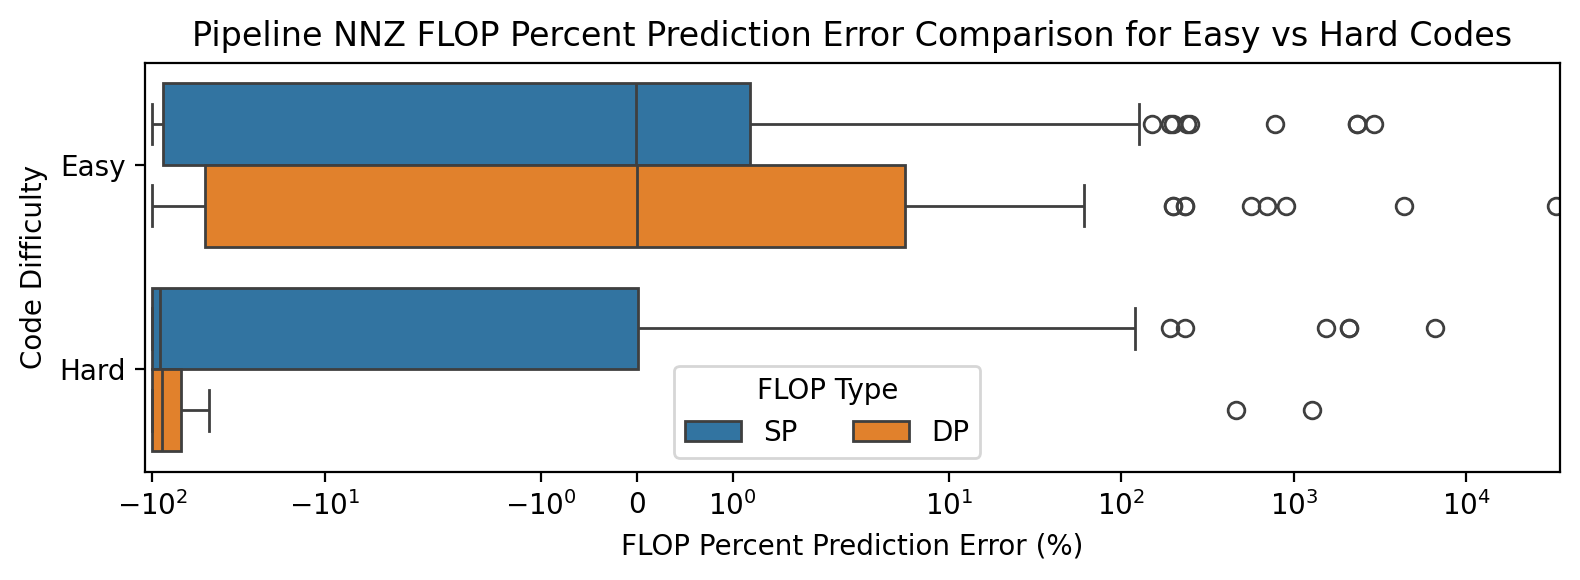

In [62]:
# for the actually easy codes, let's plot the distribution of the absolute percent error

fig, ax = plt.subplots(1, 1, figsize=(8, 3), dpi=200)

# let's do a boxplot

merged = pd.DataFrame({
    'perc_error': np.concatenate([easy_nnz_sp_errors_df['sp_perc_error'].values, 
                                  hard_nnz_sp_errors_df['sp_perc_error'].values,
                                  easy_nnz_dp_errors_df['dp_perc_error'].values,
                                  hard_nnz_dp_errors_df['dp_perc_error'].values]),
    'type': ['SP'] * len(easy_nnz_sp_errors_df) + \
            ['SP'] * len(hard_nnz_sp_errors_df) + \
            ['DP'] * len(easy_nnz_dp_errors_df) + \
            ['DP'] * len(hard_nnz_dp_errors_df),
    
    'is_easy_code': ['Easy'] * len(easy_nnz_sp_errors_df) + \
                    ['Hard'] * len(hard_nnz_sp_errors_df) + \
                    ['Easy'] * len(easy_nnz_dp_errors_df) + \
                    ['Hard'] * len(hard_nnz_dp_errors_df)

})

sns.boxplot(x='perc_error', y='is_easy_code', hue='type', data=merged, ax=ax, orient='h', showfliers=True)

ax.set_xlabel('FLOP Percent Prediction Error (%)')
ax.set_ylabel('Code Difficulty') 
ax.set_title('Pipeline NNZ FLOP Percent Prediction Error Comparison for Easy vs Hard Codes')

ax.set_xscale('symlog')

# make the legend flat on the bottom of the plot
ax.legend(title='FLOP Type', loc='lower right', bbox_to_anchor=(0.6, 0), ncol=2)

ax.set_xlim(left=-110)

plt.tight_layout()
plt.show()


In [908]:
# how many predictions are less than 0 and how many are greater than 0

sp_under_predictions = nnz_sp_errors_df[nnz_sp_errors_df['sp_perc_error'] < 0]
sp_over_predictions = nnz_sp_errors_df[nnz_sp_errors_df['sp_perc_error'] > 0]
print("Number of SP under-predictions:", len(sp_under_predictions), "(", len(sp_under_predictions) / len(nnz_sp_errors_df) * 100, "%)")
print("Number of SP over-predictions:", len(sp_over_predictions), "(", len(sp_over_predictions) / len(nnz_sp_errors_df) * 100, "%)")
print()

dp_under_predictions = nnz_dp_errors_df[nnz_dp_errors_df['dp_perc_error'] < 0]
dp_over_predictions = nnz_dp_errors_df[nnz_dp_errors_df['dp_perc_error'] > 0]
print("Number of DP under-predictions:", len(dp_under_predictions), "(", len(dp_under_predictions) / len(nnz_dp_errors_df) * 100, "%)")
print("Number of DP over-predictions:", len(dp_over_predictions), "(", len(dp_over_predictions) / len(nnz_dp_errors_df) * 100, "%)")

Number of SP under-predictions: 140 ( 65.72769953051643 %)
Number of SP over-predictions: 73 ( 34.27230046948357 %)

Number of DP under-predictions: 55 ( 65.47619047619048 %)
Number of DP over-predictions: 29 ( 34.523809523809526 %)


Num Codes in Easy Zero SP: 17
Num Codes in Easy Zero DP: 40
Num Codes in Hard Zero SP: 3
Num Codes in Hard Zero DP: 22
Num total Easy codes: 57
Num total Hard codes: 35


/var/folders/3g/gqtlwym54qj00m_k586jkf0w0000gn/T/ipykernel_48292/4177956321.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  zero_sp_errors_df['is_correct_prediction'] = zero_sp_errors_df.apply(lambda row: is_correct_prediction(row, 'SP'), axis=1)
/var/folders/3g/gqtlwym54qj00m_k586jkf0w0000gn/T/ipykernel_48292/4177956321.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  zero_dp_errors_df['is_correct_prediction'] = zero_dp_errors_df.apply(lambda row: is_correct_prediction(row, 'DP'), axis=1)


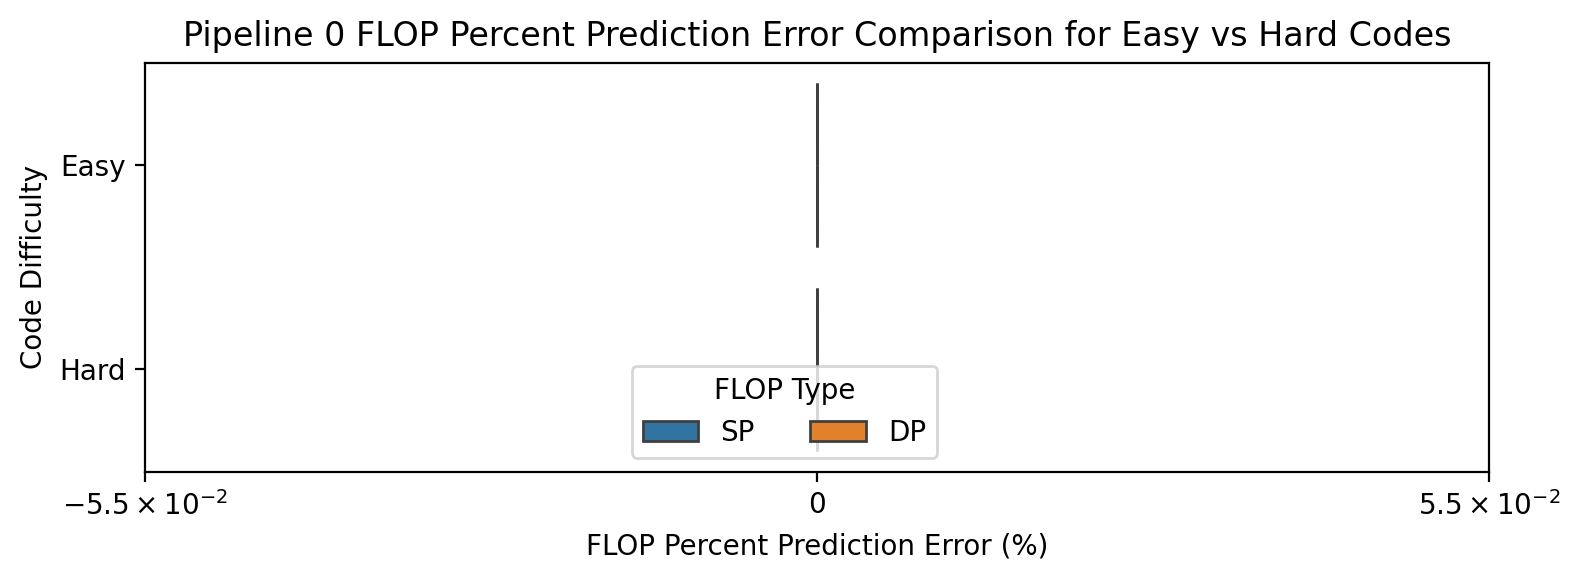

In [65]:
# for the actually easy codes, let's plot the distribution of the absolute percent error

zero_sp_errors_df['is_correct_prediction'] = zero_sp_errors_df.apply(lambda row: is_correct_prediction(row, 'SP'), axis=1)
zero_dp_errors_df['is_correct_prediction'] = zero_dp_errors_df.apply(lambda row: is_correct_prediction(row, 'DP'), axis=1)

easy_zero_sp_errors_df = zero_sp_errors_df[zero_sp_errors_df['is_easy_code'] == True]
hard_zero_sp_errors_df = zero_sp_errors_df[zero_sp_errors_df['is_easy_code'] == False]

easy_zero_dp_errors_df = zero_dp_errors_df[zero_dp_errors_df['is_easy_code'] == True]
hard_zero_dp_errors_df = zero_dp_errors_df[zero_dp_errors_df['is_easy_code'] == False]


print("Num Codes in Easy Zero SP:", easy_zero_sp_errors_df.combined_name.nunique())
print("Num Codes in Easy Zero DP:", easy_zero_dp_errors_df.combined_name.nunique())
print("Num Codes in Hard Zero SP:", hard_zero_sp_errors_df.combined_name.nunique())
print("Num Codes in Hard Zero DP:", hard_zero_dp_errors_df.combined_name.nunique())

print("Num total Easy codes:", errors_df[errors_df['is_easy_code'] == True].combined_name.nunique())
print("Num total Hard codes:", errors_df[errors_df['is_easy_code'] == False].combined_name.nunique())




fig, ax = plt.subplots(1, 1, figsize=(8, 3), dpi=200)

# let's do a boxplot

merged = pd.DataFrame({
    'perc_error': np.concatenate([easy_zero_sp_errors_df['sp_perc_error'].values, 
                                  hard_zero_sp_errors_df['sp_perc_error'].values,
                                  easy_zero_dp_errors_df['dp_perc_error'].values,
                                  hard_zero_dp_errors_df['dp_perc_error'].values]),
    'type': ['SP'] * len(easy_zero_sp_errors_df) + \
            ['SP'] * len(hard_zero_sp_errors_df) + \
            ['DP'] * len(easy_zero_dp_errors_df) + \
            ['DP'] * len(hard_zero_dp_errors_df),

    'is_easy_code': ['Easy'] * len(easy_zero_sp_errors_df) + \
                    ['Hard'] * len(hard_zero_sp_errors_df) + \
                    ['Easy'] * len(easy_zero_dp_errors_df) + \
                    ['Hard'] * len(hard_zero_dp_errors_df)

})

sns.boxplot(x='perc_error', y='is_easy_code', hue='type', data=merged, ax=ax, orient='h', showfliers=True)

ax.set_xlabel('FLOP Percent Prediction Error (%)')
ax.set_ylabel('Code Difficulty') 
ax.set_title('Pipeline 0 FLOP Percent Prediction Error Comparison for Easy vs Hard Codes')

ax.set_xscale('symlog')

# make the legend flat on the bottom of the plot
ax.legend(title='FLOP Type', loc='lower right', bbox_to_anchor=(0.6, 0), ncol=2)

#ax.set_xlim(left=-110)

plt.tight_layout()
plt.show()


/var/folders/3g/gqtlwym54qj00m_k586jkf0w0000gn/T/ipykernel_17980/1462957568.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  nnz_sp_errors_df['error_bin'] = pd.cut(nnz_sp_errors_df['sp_perc_error'], bins=bins, labels=labels, right=False)
/var/folders/3g/gqtlwym54qj00m_k586jkf0w0000gn/T/ipykernel_17980/1462957568.py:43: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  heatmap_data[i] = nnz_sp_errors_df.groupby('error_bin')[category].sum()
/var/folders/3g/gqtlwym54qj00m_k586jkf0w0000gn/T/ipykernel_17980/1462957568.py:43: FutureWarning: The default of observed

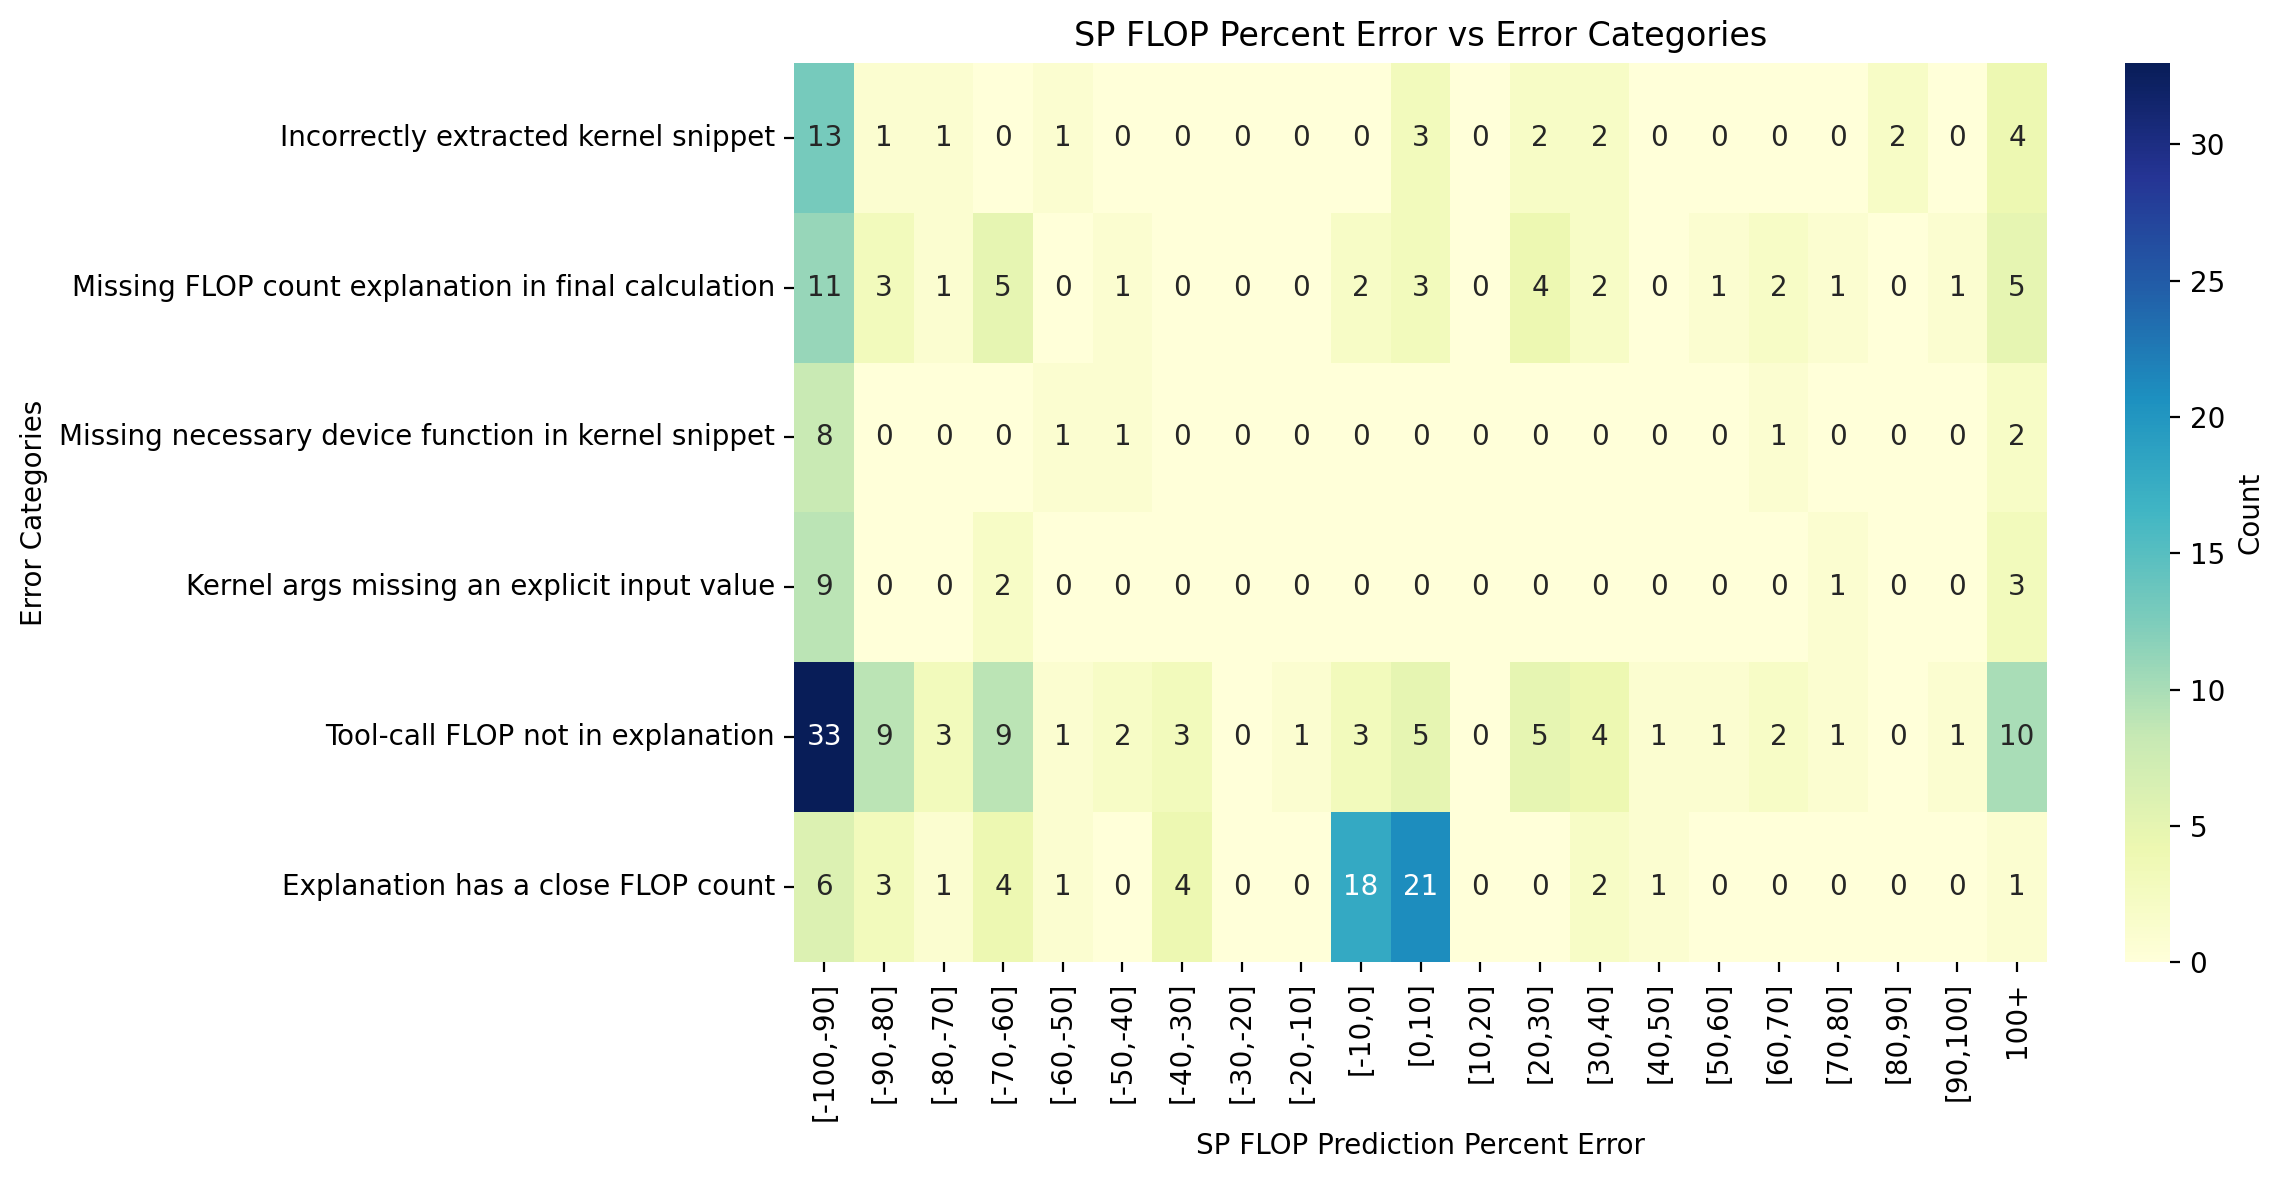

In [865]:
# let's define the error categories
# 1: not an easy code (is_easy_code == False)
# 2: incorrectly extracted kernel snippet (extractedIncorrectSnippet == 1)
# 3: missing SP FLOP explanation (missingSPFLOPExplanation == 1)
# 4: missing DP FLOP explanation (missingDPFLOPExplanation == 1)
# 5: missing necessary device function in extracted snippet (missingNecessaryDeviceFunction == 1)
# 6: extracted kernel args missing important input value (extractedKernelArgsMissingImportantValue == 1)
# 7: incorrectly completed tool call (toolCallExplanationSPFLOPCountMismatch == 1 or toolCallExplanationDPFLOPCountMismatch == 1)

# let's make a heatmap and see if there is a category of error that is more common than others

# Define bins for sp_abs_perc_error
bins = list(range(-100, 101, 10)) + [float('inf')]  # -100-10, 10-20, ..., 90-100, 100+
labels = [f"[{i},{i+10}]" for i in range(-100, 100, 10)] + ["100+"]

# Bin the sp_abs_perc_error values
nnz_sp_errors_df['error_bin'] = pd.cut(nnz_sp_errors_df['sp_perc_error'], bins=bins, labels=labels, right=False)

# Define error categories
error_categories = [
    'extractedIncorrectSnippet',
    'missingSPFLOPExplanation',
    'missing_necessary_device_function',
    'extractedKernelArgsMissingImportantValue',
    'toolCallExplanationSPFLOPCountMismatch',
    'spExplanationHasCloseFLOPCount',
]

# Define a mapping of error categories to descriptive strings
error_category_descriptions = {
    1: "Incorrectly extracted kernel snippet",
    2: "Missing FLOP count explanation in final calculation",
    3: "Missing necessary device function in kernel snippet",
    4: "Kernel args missing an explicit input value",
    5: "Tool-call FLOP not in explanation",
    6: "Explanation has a close FLOP count"
}

# Create a DataFrame to count occurrences of each error category in each bin
heatmap_data = pd.DataFrame(0, index=labels, columns=range(1, len(error_categories)))

for i, category in enumerate(error_categories, start=1):
    heatmap_data[i] = nnz_sp_errors_df.groupby('error_bin')[category].sum()

# Update the Y-axis labels to use descriptive strings
heatmap_data = heatmap_data.rename(columns=error_category_descriptions)

# Plot the heatmap with swapped axes
plt.figure(figsize=(12, 6), dpi=200)
sns.heatmap(heatmap_data.T, annot=True, fmt="d", cmap="YlGnBu", cbar_kws={'label': 'Count'})
plt.ylabel("Error Categories")
plt.xlabel("SP FLOP Prediction Percent Error")
plt.title("SP FLOP Percent Error vs Error Categories")
plt.tight_layout()
plt.show()



/var/folders/3g/gqtlwym54qj00m_k586jkf0w0000gn/T/ipykernel_17980/2142559423.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  nnz_dp_errors_df['error_bin'] = pd.cut(nnz_dp_errors_df['dp_perc_error'], bins=bins, labels=labels, right=False)
/var/folders/3g/gqtlwym54qj00m_k586jkf0w0000gn/T/ipykernel_17980/2142559423.py:35: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  heatmap_data[i] = nnz_dp_errors_df.groupby('error_bin')[category].sum()
/var/folders/3g/gqtlwym54qj00m_k586jkf0w0000gn/T/ipykernel_17980/2142559423.py:35: FutureWarning: The default of observed

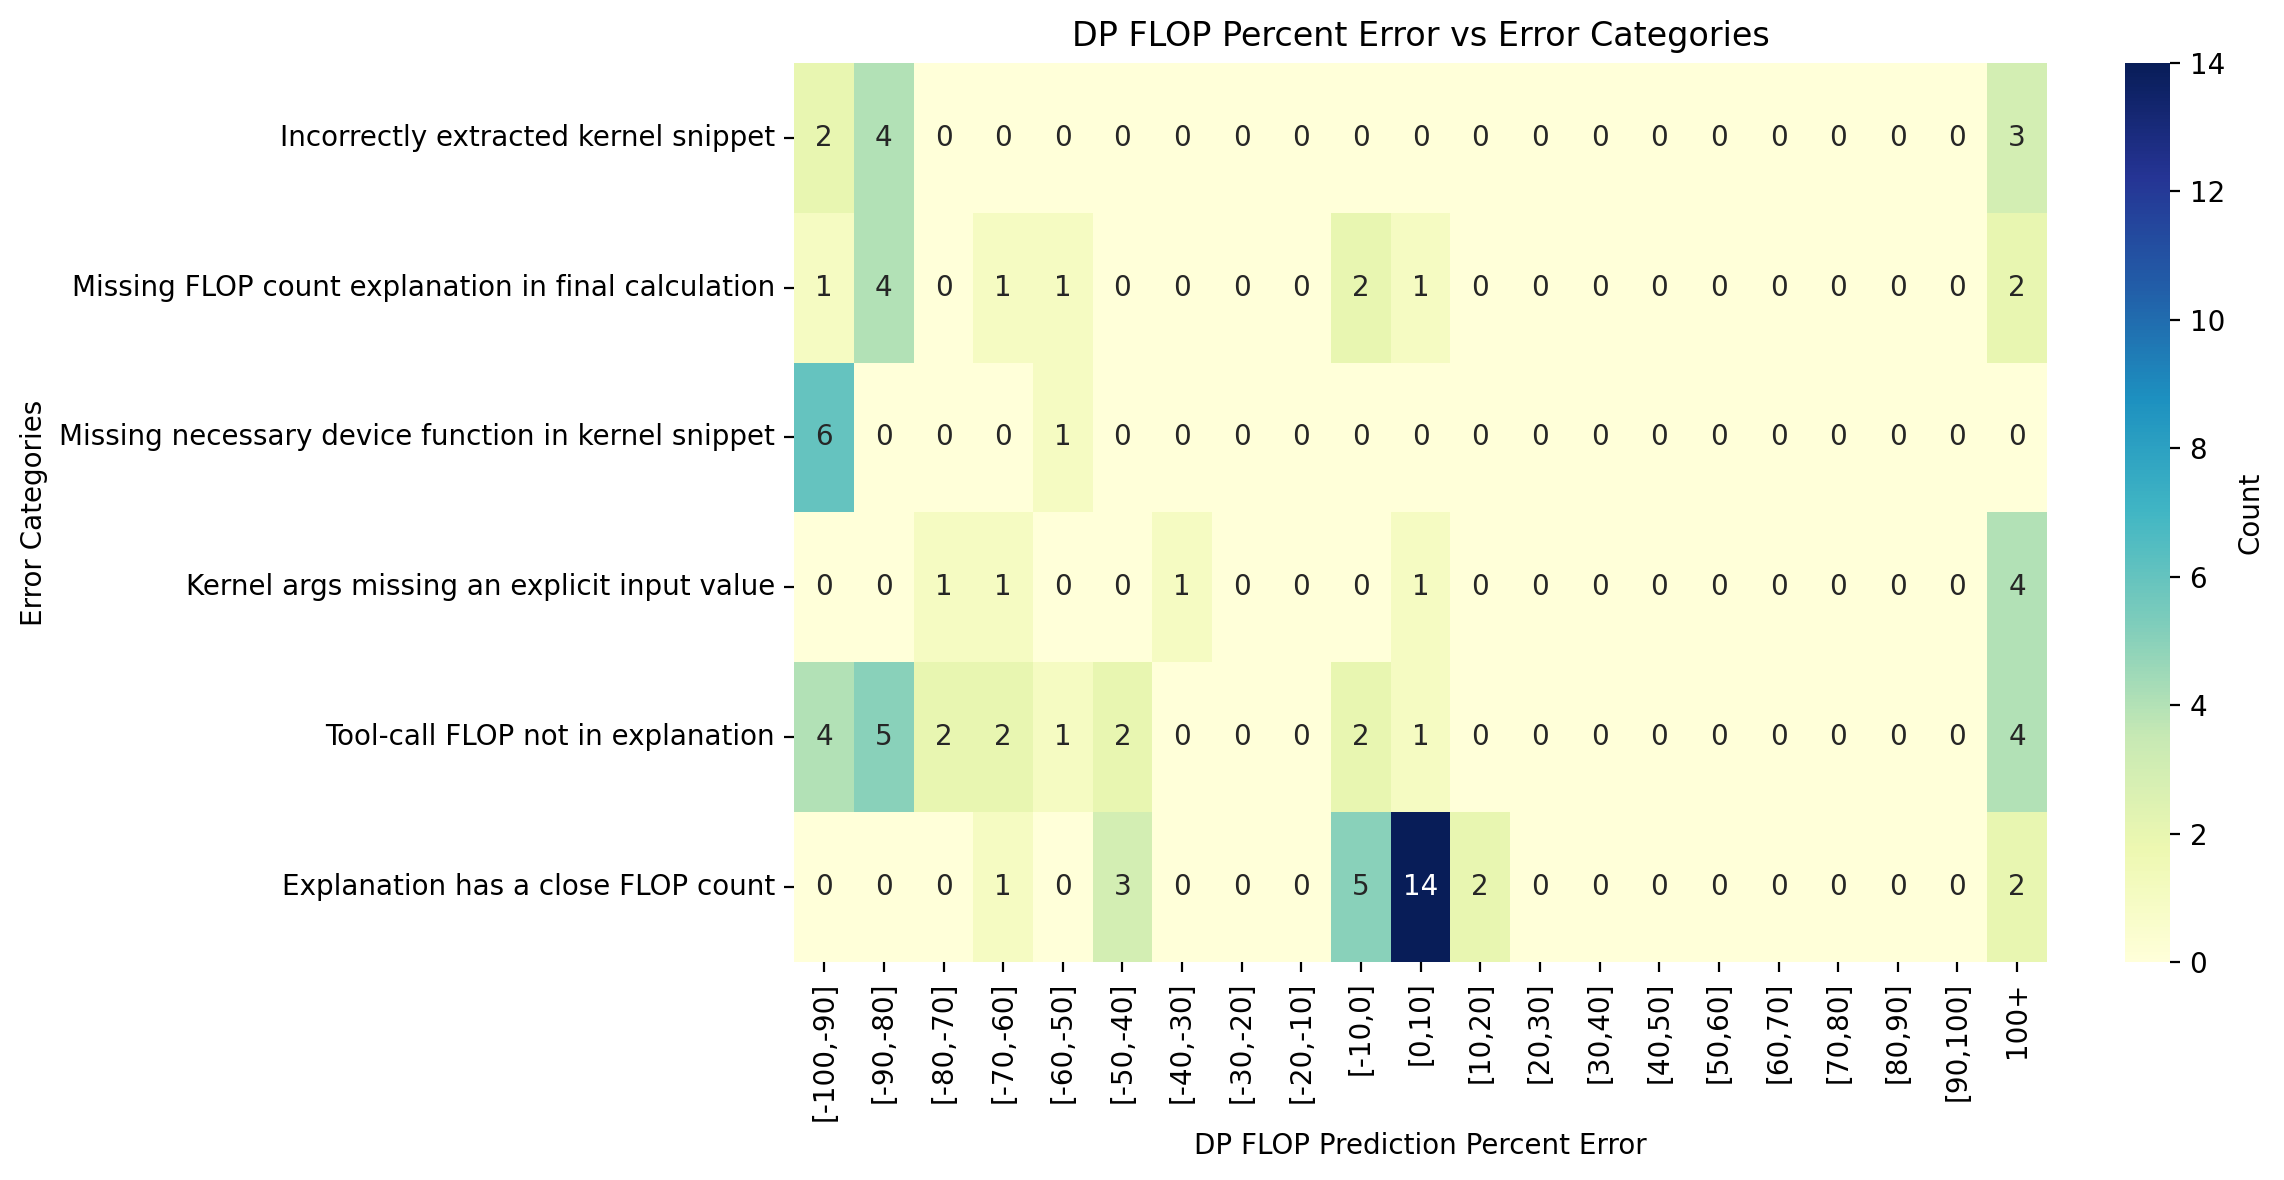

In [866]:
# let's define the error categories
# 1: not an easy code (is_easy_code == False)
# 2: incorrectly extracted kernel snippet (extractedIncorrectSnippet == 1)
# 3: missing SP FLOP explanation (missingSPFLOPExplanation == 1)
# 4: missing DP FLOP explanation (missingDPFLOPExplanation == 1)
# 5: missing necessary device function in extracted snippet (missingNecessaryDeviceFunction == 1)
# 6: extracted kernel args missing important input value (extractedKernelArgsMissingImportantValue == 1)
# 7: incorrectly completed tool call (toolCallExplanationSPFLOPCountMismatch == 1 or toolCallExplanationDPFLOPCountMismatch == 1)

# let's make a heatmap and see if there is a category of error that is more common than others

# Define bins for sp_abs_perc_error
#bins = list(range(0, 101, 10)) + [float('inf')]  # 0-10, 10-20, ..., 90-100, 100+
#labels = [f"{i}-{i+10}" for i in range(0, 100, 10)] + ["100+"]

# Bin the dp_abs_perc_error values
nnz_dp_errors_df['error_bin'] = pd.cut(nnz_dp_errors_df['dp_perc_error'], bins=bins, labels=labels, right=False)

# Define error categories
error_categories = [
    'extractedIncorrectSnippet',
    'missingDPFLOPExplanation',
    'missing_necessary_device_function',
    'extractedKernelArgsMissingImportantValue',
    'toolCallExplanationDPFLOPCountMismatch',
    'dpExplanationHasCloseFLOPCount',
]

# Define a mapping of error categories to descriptive strings

# Create a DataFrame to count occurrences of each error category in each bin
heatmap_data = pd.DataFrame(0, index=labels, columns=range(1, len(error_categories)))

for i, category in enumerate(error_categories, start=1):
    heatmap_data[i] = nnz_dp_errors_df.groupby('error_bin')[category].sum()

# Update the Y-axis labels to use descriptive strings
heatmap_data = heatmap_data.rename(columns=error_category_descriptions)

# Plot the heatmap with swapped axes
plt.figure(figsize=(12, 6), dpi=200)
sns.heatmap(heatmap_data.T, annot=True, fmt="d", cmap="YlGnBu", cbar_kws={'label': 'Count'})
plt.ylabel("Error Categories")
plt.xlabel("DP FLOP Prediction Percent Error")
plt.title("DP FLOP Percent Error vs Error Categories")
plt.tight_layout()
plt.show()



/var/folders/3g/gqtlwym54qj00m_k586jkf0w0000gn/T/ipykernel_17980/1851302828.py:38: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  heatmap_data[i] = errors_df.groupby('error_bin')[category].sum()
/var/folders/3g/gqtlwym54qj00m_k586jkf0w0000gn/T/ipykernel_17980/1851302828.py:38: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  heatmap_data[i] = errors_df.groupby('error_bin')[category].sum()
/var/folders/3g/gqtlwym54qj00m_k586jkf0w0000gn/T/ipykernel_17980/1851302828.py:38: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to reta

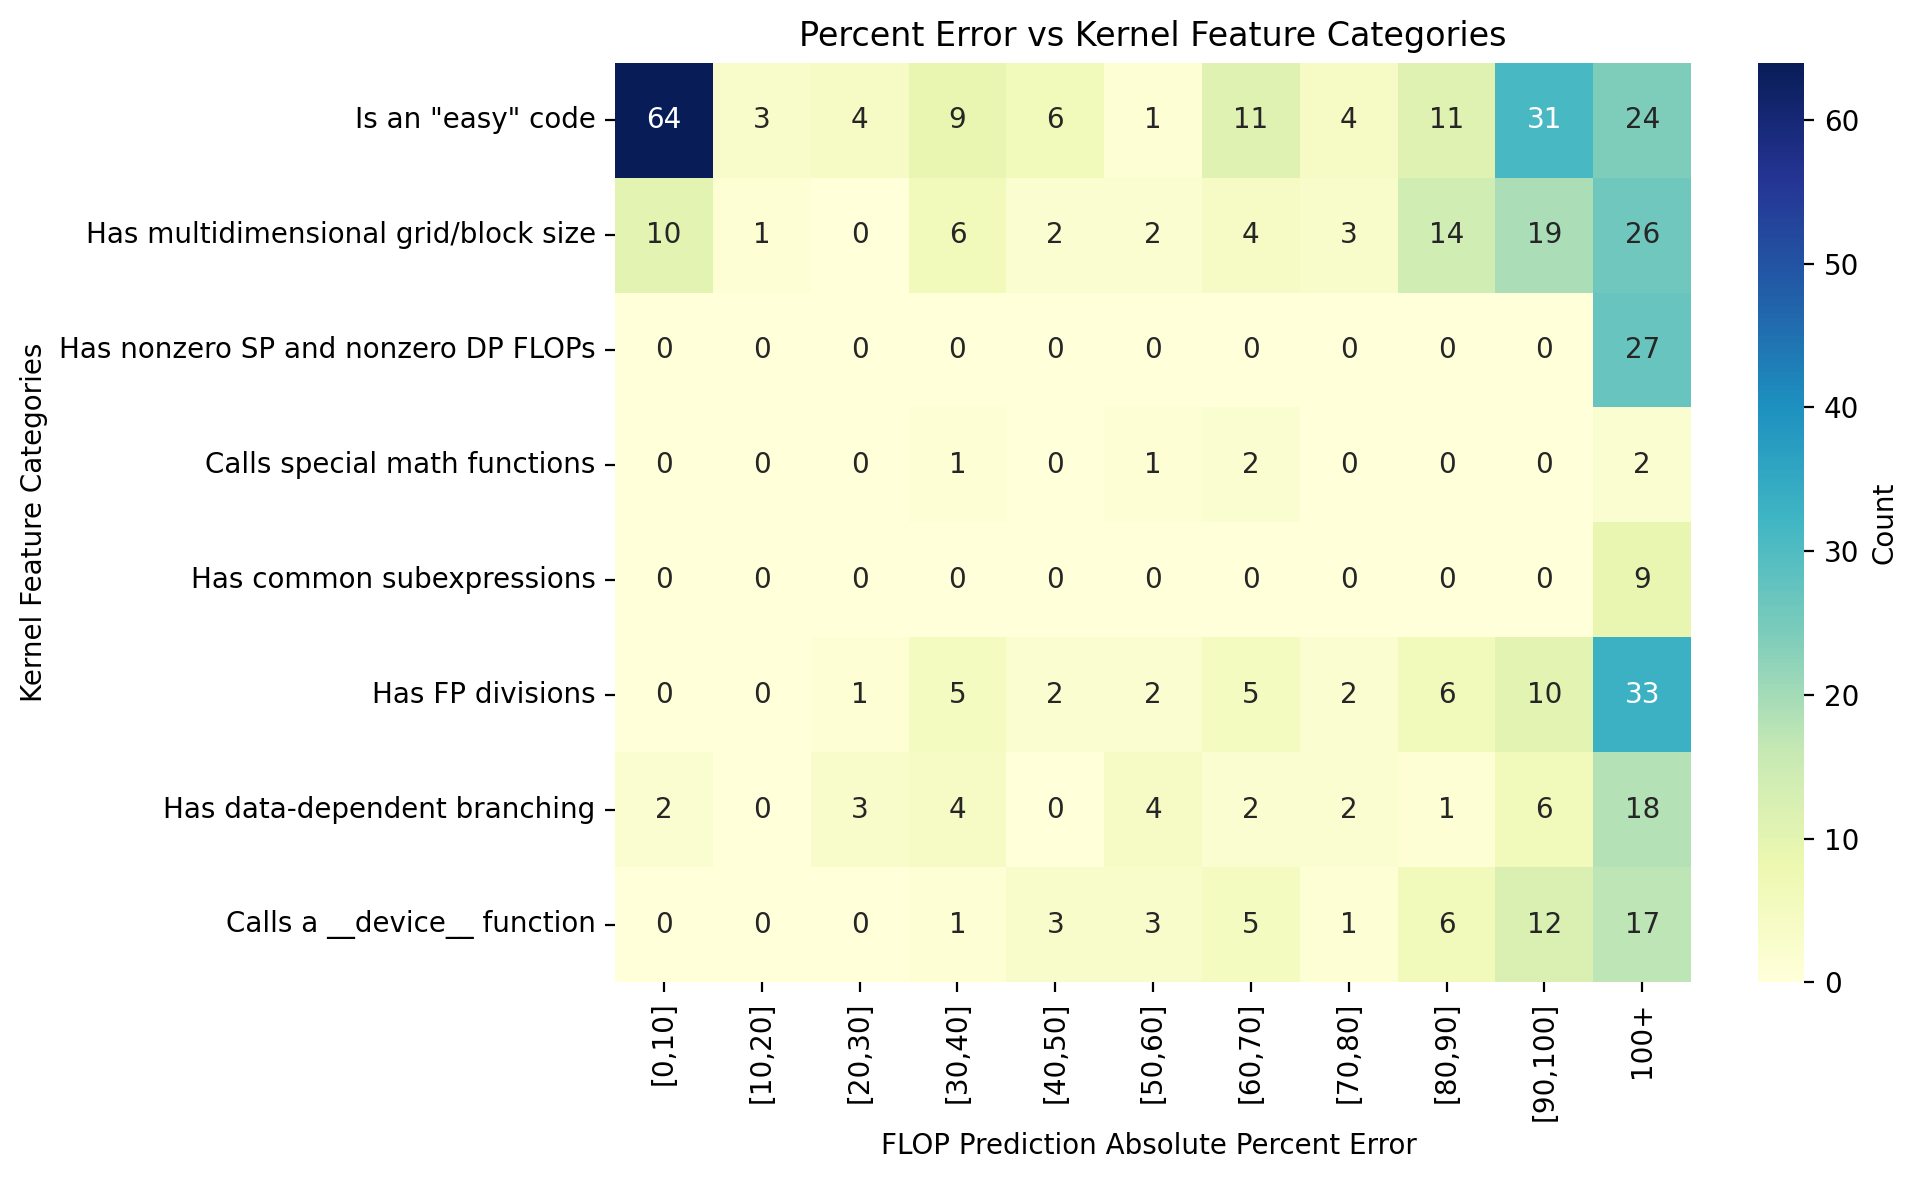

In [867]:
# now let's plot code features vs absolute percentage error


feature_categories = [
    'is_easy_code', 
    'hasMultidimGridBlkSize', 
    'hasSPandDPnnzFlops',
    'hasSpecialMathFunctions', 
    'hasCommonSubexpressions', 
    'hasFPDivisions',
    'hasDDBranching', 
    'callsDeviceFunction'
]

# Define a mapping of error categories to descriptive strings
feature_category_descriptions = {
    1: "Is an \"easy\" code",
    2: "Has multidimensional grid/block size",
    3: "Has nonzero SP and nonzero DP FLOPs",
    4: "Calls special math functions",
    5: "Has common subexpressions",
    6: "Has FP divisions",
    7: "Has data-dependent branching",
    8: "Calls a __device__ function"
}

bins = list(range(0, 101, 10)) + [float('inf')]  # 0-10, 10-20, ..., 90-100, 100+
labels = [f"[{i},{i+10}]" for i in range(0, 100, 10)] + ["100+"]


errors_df['max_abs_error'] = errors_df[['sp_abs_perc_error', 'dp_abs_perc_error']].max(axis=1)
errors_df['error_bin'] = pd.cut(errors_df['max_abs_error'], bins=bins, labels=labels, right=False)

# Create a DataFrame to count occurrences of each error category in each bin
heatmap_data = pd.DataFrame(0, index=labels, columns=range(1, len(feature_categories)))

for i, category in enumerate(feature_categories, start=1):
    heatmap_data[i] = errors_df.groupby('error_bin')[category].sum()

# Update the Y-axis labels to use descriptive strings
heatmap_data = heatmap_data.rename(columns=feature_category_descriptions)

plt.figure(figsize=(10, 6), dpi=200)
sns.heatmap(heatmap_data.T, annot=True, fmt="d", cmap="YlGnBu", cbar_kws={'label': 'Count'})
plt.ylabel("Kernel Feature Categories")
plt.xlabel("FLOP Prediction Absolute Percent Error ")
plt.title("Percent Error vs Kernel Feature Categories")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()